Description for which files are where, what is needed

### What you need

This tutorial goes from parsing data to visualizing the posterior of MDSINE2.

The tables that you will need are:
* taxa counts
* qPCR table
* perturbations table
* taxonomy table
* metadata file

Our data is preprocessed in objects from a previous tutorial. For this tutorial we unpacking our data into it's composite tables to walk you through constructing your own `Study` objects


In [1]:
%matplotlib inline

import mdsine2 as md2
from mdsine2.names import STRNAMES
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import logging

md2.LoggingConfig(level=logging.INFO)

In [2]:
# Make example datasets from preprocessed data
def make_toy(dset):
    to_delete = []
    for taxa in dset.taxas:
        if taxa.idx >= 15:
            to_delete.append(taxa.name)
    dset.pop_taxas(to_delete)
    
    os.makedirs(os.path.join('data',dset.name+'-toy'), exist_ok=True)
    dset.write_metadata_to_csv(path=os.path.join('data',dset.name+'-toy','metadata.tsv'))
    dset.write_qpcr_to_csv(path=os.path.join('data',dset.name+'-toy','qpcr.tsv'))
    if dset.perturbations is not None:
        dset.write_perturbations_to_csv(path=os.path.join('data',dset.name+'-toy','perturbations.tsv'))
    dset.write_reads_to_csv(path=os.path.join('data',dset.name+'-toy','reads.tsv'))
    dset.taxas.write_taxonomy_to_csv(path=os.path.join('data',dset.name+'-toy','taxonomy.tsv'))

In [3]:
healthy = md2.Study.load('../processed_data/gibson_healthy_agg_taxa_filtered.pkl')
uc = md2.Study.load('../processed_data/gibson_uc_agg_taxa_filtered.pkl')
replicates = md2.Study.load('../processed_data/gibson_replicates_agg_taxa_filtered.pkl')

make_toy(dset=healthy)
make_toy(dset=uc)
make_toy(dset=replicates)

### Metadata table
The following table is a metadata table. It tells the `Study` object what subject and timepoint each sample belongs to

In [4]:
# Load metadata table
metadata = pd.read_csv('data/healthy-toy/metadata.tsv', sep='\t')
metadata.head()

,sampleID,subject,time
0,2-D10,2,10.0
1,2-D11,2,11.0
2,2-D14,2,14.0
3,2-D16,2,16.0
4,2-D18,2,18.0


### qPCR table
The following table is a qPCR table. This has the replicate measurements of the qPCR for every sample.

In [5]:
# qPCR table
qpcr = pd.read_csv('data/healthy-toy/qpcr.tsv', sep='\t')
qpcr.head()

,sampleID,measurement1,measurement2,measurement3
0,2-D10,4.129004e+10,6.423568e+10,8.384557e+10
1,2-D11,2.981363e+10,6.587538e+10,5.077812e+10
2,2-D14,1.647771e+10,7.104907e+10,2.498869e+10
3,2-D16,3.666487e+10,6.237899e+10,3.875999e+10
4,2-D18,4.523257e+10,2.320504e+10,2.330249e+10


### Perturbation table
The following table is a perturbation table. This tells the `Study` object which subject has a perturbation and when. There can be multiple perturbations for each subject. Note that this is only necessary if you have perturbations in your dataset.

In [6]:
perturbations = pd.read_csv('data/healthy-toy/perturbations.tsv', sep='\t')
perturbations

,name,start,end,subject
0,High Fat Diet,21.5,28.5,2
1,High Fat Diet,21.5,28.5,3
2,High Fat Diet,21.5,28.5,4
3,High Fat Diet,21.5,28.5,5
4,Vancomycin,35.5,42.5,2
5,Vancomycin,35.5,42.5,3
6,Vancomycin,35.5,42.5,4
7,Vancomycin,35.5,42.5,5
8,Gentamicin,50.5,57.5,2
9,Gentamicin,50.5,57.5,3


### Reads table
The following table is a reads table. This shows the number of counts each taxa has for each sample ID.

In [7]:
reads = pd.read_csv('data/healthy-toy/reads.tsv', sep='\t')
reads.head()

,name,2-D10,2-D11,2-D14,2-D16,2-D18,2-D1AM,2-D1PM,2-D21AM,2-D21PM,2-D22AM,2-D22PM,2-D23AM,2-D23PM,2-D24,2-D25,2-D28AM,2-D28PM,2-D29AM,2-D29PM,2-D2AM,2-D2PM,2-D30AM,2-D30PM,2-D31AM,2-D31PM,2-D32,2-D33,2-D35AM,2-D35PM,2-D36AM,2-D36PM,2-D37AM,2-D37PM,2-D38,2-D39,2-D3AM,2-D3PM,2-D42AM,2-D42PM,2-D43AM,2-D43PM,2-D44AM,2-D44PM,2-D45AM,2-D45PM,2-D46,2-D47,2-D4AM,2-D4PM,2-D5,2-D50AM,2-D50PM,2-D51AM,2-D51PM,2-D52AM,2-D52PM,2-D53,2-D54,2-D57AM,2-D57PM,2-D58AM,2-D58PM,2-D59AM,2-D59PM,2-D6,2-D60AM,2-D60PM,2-D61,2-D62,2-D63,2-D64AM,2-D64PM,2-D7,2-D8,2-D9,3-D10,3-D11,3-D14,3-D16,3-D18,3-D1AM,3-D1PM,3-D21AM,3-D21PM,3-D22AM,3-D22PM,3-D23AM,3-D23PM,3-D24,3-D25,3-D28AM,3-D29AM,3-D29PM,3-D2AM,3-D2PM,3-D30AM,3-D30PM,3-D31AM,3-D31PM,3-D32,3-D33,3-D35AM,3-D35PM,3-D36AM,3-D36PM,3-D37AM,3-D38,3-D39,3-D3AM,3-D3PM,3-D42AM,3-D42PM,3-D43AM,3-D43PM,3-D44AM,3-D44PM,3-D45AM,3-D45PM,3-D46,3-D47,3-D4AM,3-D4PM,3-D5,3-D50AM,3-D50PM,3-D51AM,3-D51PM,3-D52AM,3-D52PM,3-D53,3-D54,3-D57AM,3-D57PM,3-D58AM,3-D58PM,3-D59AM,3-D59PM,3-D6,3-D60AM,3-D60PM,3-D61,3-D62,3-D63,3-D64AM,3-D64PM,3-D7,3-D8,3-D9,4-D10,4-D11,4-D14,4-D16,4-D18,4-D1AM,4-D1PM,4-D21AM,4-D21PM,4-D22AM,4-D22PM,4-D23AM,4-D23PM,4-D24,4-D25,4-D28AM,4-D29AM,4-D29PM,4-D2AM,4-D2PM,4-D30AM,4-D30PM,4-D31AM,4-D31PM,4-D32,4-D33,4-D35AM,4-D35PM,4-D36AM,4-D36PM,4-D37AM,4-D37PM,4-D38,4-D39,4-D3AM,4-D3PM,4-D42AM,4-D42PM,4-D43AM,4-D43PM,4-D44AM,4-D44PM,4-D45AM,4-D45PM,4-D46,4-D47,4-D4AM,4-D4PM,4-D5,4-D50AM,4-D50PM,4-D51AM,4-D51PM,4-D52AM,4-D52PM,4-D53,4-D54,4-D57AM,4-D57PM,4-D58AM,4-D58PM,4-D59AM,4-D59PM,4-D6,4-D60AM,4-D60PM,4-D61,4-D62,4-D63,4-D64AM,4-D64PM,4-D7,4-D8,4-D9,5-D10,5-D11,5-D14,5-D16,5-D18,5-D1AM,5-D1PM,5-D21AM,5-D21PM,5-D22AM,5-D22PM,5-D23AM,5-D23PM,5-D24,5-D25,5-D28AM,5-D28PM,5-D29AM,5-D29PM,5-D2AM,5-D2PM,5-D30AM,5-D30PM,5-D31AM,5-D31PM,5-D32,5-D33,5-D35AM,5-D35PM,5-D36AM,5-D36PM,5-D37AM,5-D37PM,5-D38,5-D39,5-D3AM,5-D3PM,5-D42AM,5-D42PM,5-D43AM,5-D43PM,5-D44AM,5-D44PM,5-D45AM,5-D45PM,5-D46,5-D47,5-D4AM,5-D4PM,5-D5,5-D50AM,5-D50PM,5-D51AM,5-D51PM,5-D52AM,5-D52PM,5-D53,5-D54,5-D57AM,5-D57PM,5-D58AM,5-D58PM,5-D59AM,5-D59PM,5-D6,5-D60AM,5-D60PM,5-D61,5-D62,5-D63,5-D64AM,5-D64PM,5-D7,5-D8,5-D9
0,OTU_1,1227,1793,8023,9503,3243,1830,199,3539,5270,3866,3899,1984,807,2299,1349,1074,855,3479,3910,489,1056,5113,5624,7096,5788,10237,2784,2711,2421,1554,1216,259,154,114,100,1474,3227,1963,2950,126,202,207,222,89,50,185,180,7637,4237,5597,53,47,29,48,162,37,188,2349,5520,3265,3892,3881,1646,1805,6129,1913,6688,1730,1269,651,987,853,9591,2503,234,6265,6822,1831,2874,6154,235,202,7102,7624,6024,3889,4683,5921,3608,4278,2865,5330,7488,340,227,7926,5061,5108,4923,4988,5879,4039,4822,3009,4213,609,197,123,1398,1945,1365,1652,4512,741,455,461,99,54,386,134,4408,4276,2734,124,209,55,80,249,107,341,109,168,194,713,637,539,564,3804,806,891,833,775,545,525,845,4798,4650,5987,398,1744,11041,9437,9948,4695,195,5562,3920,1638,1210,1235,639,929,1277,4084,5681,6144,222,176,4690,3737,5519,5504,3350,6638,3696,3697,1529,2179,3757,1466,182,96,183,461,8678,7682,5384,2311,1032,1101,263,153,426,167,1900,2509,3240,157,182,71,59,267,154,133,109,116,36,122,90,20,13,6844,125,63,96,63,51,34,76,5459,3853,585,5152,4173,11816,5113,5642,5033,230,6454,5745,4194,7218,8262,1512,2093,3224,2091,1650,3840,11932,620,852,8741,5593,6152,3740,500,307,52,77,99,95,182,135,135,123,1198,3491,395,38,60,35,96,136,38,27,137,162,3943,5485,5746,49,103,39,80,222,205,115,29,73,135,140,223,83,192,6401,218,409,2072,1160,723,1043,1732,4698,3310,4495
1,OTU_2,17362,6887,17165,29854,36759,2929,9880,15863,20619,2725,1792,466,51,86,38,25,34,1317,2217,24422,17184,5490,5924,6906,7466,9783,7856,10490,9939,18164,17769,16694,8553,8842,5806,11193,15984,8567,6995,5108,6693,5785,6963,5880,6755,8239,7199,21915,13035,15798,625,751,2368,2556,632,206,278,177,644,1857,5473,5433,2847,2693,14811,2652,8942,3765,4053,2497,4608,4569,12926,8541,12646,11800,14693,20597,10165,19883,8032,19079,24905,21860,2601,1059,309,152,130,124,46,1130,3653,23489,17698,9339,7694,7429,8762,9965,15319,9470,13328,1292

### Taxonomy table
The following table is a taxonomy table. For each taxa name, it shows the sequence and taxonomy

In [8]:
taxonomy = pd.read_csv('data/healthy-toy/taxonomy.tsv', sep='\t')
taxonomy

,name,sequence,kingdom,phylum,class,order,family,genus,species
0,OTU_1,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,NaN
1,OTU_2,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,fragilis/ovatus
2,OTU_3,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Akkermansiaceae,Akkermansia,muciniphila
3,OTU_4,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,NaN
4,OTU_5,TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGGGTG...,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Sutterellaceae,Parasutterella,excrementihominis
5,OTU_6,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,fragilis/dorei
6,OTU_7,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,caccae
7,OTU_8,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,salyersiae
8,OTU_9,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,NaN
9,OTU_10,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,uniformis


With these 5 tables, you can run our model. You can parse them directly into a `Study` object with the `mdsine2.dataset.parse` command:

In [9]:
h_toy = md2.dataset.parse(name='healthy-toy-dataset', 
                         taxonomy='data/healthy-toy/taxonomy.tsv', 
                         reads='data/healthy-toy/reads.tsv', 
                         qpcr='data/healthy-toy/qpcr.tsv', 
                         perturbations='data/healthy-toy/perturbations.tsv', 
                         metadata='data/healthy-toy/metadata.tsv')
uc_toy = md2.dataset.parse(name='uc-toy-dataset', 
                         taxonomy='data/uc-toy/taxonomy.tsv', 
                         reads='data/uc-toy/reads.tsv', 
                         qpcr='data/uc-toy/qpcr.tsv', 
                         perturbations='data/uc-toy/perturbations.tsv', 
                         metadata='data/uc-toy/metadata.tsv')
rep_toy = md2.dataset.parse(name='replicates-toy-dataset', 
                         taxonomy='data/replicates-toy/taxonomy.tsv', 
                         reads='data/replicates-toy/reads.tsv', 
                         qpcr='data/replicates-toy/qpcr.tsv', 
                         metadata='data/replicates-toy/metadata.tsv')


INFO:base.1117: TaxaSet parsng new taxonomy table. Resetting
INFO:base.1117: TaxaSet parsng new taxonomy table. Resetting
INFO:base.1117: TaxaSet parsng new taxonomy table. Resetting


You would just read these in with this parser. These are identical to our precomputed dataset 

# Learning the Negative Binomial dispersion parameters

This corresponds to the script ``

words here

In [10]:
# Description

In [11]:
params = md2.config.NegBinConfig(
    seed=0, burnin=100, n_samples=200,
    ckpt=100, basepath='output/negbin/run2')

description

In [12]:
mcmc_negbin = md2.negbin.build_graph(params=params, graph_name=rep_toy.name, 
                              subjset=rep_toy)

INFO:inference.550: Setting Single Write, Multiple Read Mode
INFO:inference.555: Setting the trace of learned parameters
INFO:inference.556: #######################################
INFO:inference.558: Setting the trace of Negative binomial dispersion a0
INFO:inference.558: Setting the trace of Negative binomial dispersion a1
INFO:inference.558: Setting the trace of Filtering
INFO:inference.560: Setting the trace for diagnostic variables
INFO:inference.561: ##########################################


description

In [13]:
mcmc_negbin = md2.negbin.run_graph(mcmc_negbin, crash_if_error=True)

INFO:inference.429: 

Inference iteration 0/200, time: 0.0
INFO:inference.438: Negative binomial dispersion a0: 1e-10
INFO:inference.438: Negative binomial dispersion a1: 0.1
INFO:inference.438: Filtering: NA
INFO:inference.429: 

Inference iteration 1/200, time: 0.6040167808532715
INFO:inference.438: Negative binomial dispersion a0: Value: 1e-10, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispersion a1: Value: 0.09932993484270942, Acceptance rate: 1.0
INFO:inference.438: Filtering: no-mp : Time: 0.2880, Acc: [0.333, 0.200, 0.333], data/sec: 156.24
INFO:inference.429: 

Inference iteration 2/200, time: 0.006031990051269531
INFO:inference.438: Negative binomial dispersion a0: Value: 9.612139383543583e-11, Acceptance rate: 0.5
INFO:inference.438: Negative binomial dispersion a1: Value: 0.07611843510778384, Acceptance rate: 1.0
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.333, 0.267, 0.533], data/sec: 14829.01
INFO:inference.429: 

Inference iteration 3/200

INFO:inference.438: Negative binomial dispersion a0: Value: 5.433152020006895e-11, Acceptance rate: 0.42857142857142855
INFO:inference.438: Negative binomial dispersion a1: Value: 0.05290413764815772, Acceptance rate: 0.6190476190476191
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.267, 0.267, 0.267], data/sec: 14987.98
INFO:inference.429: 

Inference iteration 22/200, time: 0.00602412223815918
INFO:inference.438: Negative binomial dispersion a0: Value: 5.096746550369834e-11, Acceptance rate: 0.45454545454545453
INFO:inference.438: Negative binomial dispersion a1: Value: 0.05290413764815772, Acceptance rate: 0.5909090909090909
INFO:inference.438: Filtering: no-mp : Time: 0.0020, Acc: [0.400, 0.333, 0.467], data/sec: 22223.44
INFO:inference.429: 

Inference iteration 23/200, time: 0.008025407791137695
INFO:inference.438: Negative binomial dispersion a0: Value: 3.436668653129214e-11, Acceptance rate: 0.4782608695652174
INFO:inference.438: Negative binomial dispersion a1: V

INFO:inference.438: Negative binomial dispersion a1: Value: 0.05659787402060928, Acceptance rate: 0.6341463414634146
INFO:inference.438: Filtering: no-mp : Time: 0.0040, Acc: [0.333, 0.533, 0.267], data/sec: 11370.10
INFO:inference.429: 

Inference iteration 42/200, time: 0.005999088287353516
INFO:inference.438: Negative binomial dispersion a0: Value: 2.0481344749675447e-12, Acceptance rate: 0.40476190476190477
INFO:inference.438: Negative binomial dispersion a1: Value: 0.05659787402060928, Acceptance rate: 0.6190476190476191
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.200, 0.333, 0.133], data/sec: 14987.98
INFO:inference.429: 

Inference iteration 43/200, time: 0.006004810333251953
INFO:inference.438: Negative binomial dispersion a0: Value: 2.0481344749675447e-12, Acceptance rate: 0.3953488372093023
INFO:inference.438: Negative binomial dispersion a1: Value: 0.05003316278345163, Acceptance rate: 0.627906976744186
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Ac

INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.24
INFO:inference.438: Negative binomial dispersion a1: Value: 0.07591896190663665, Acceptance rate: 0.56
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.333, 0.400, 0.333], data/sec: 15168.66
INFO:inference.429: 

Inference iteration 63/200, time: 0.006002664566040039
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.22
INFO:inference.438: Negative binomial dispersion a1: Value: 0.06881053138741283, Acceptance rate: 0.56
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.467, 0.400, 0.467], data/sec: 15003.47
INFO:inference.429: 

Inference iteration 64/200, time: 0.0059854984283447266
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.22
INFO:inference.438: Negative binomial dispersion a1: Value: 0.06514442553913363, Acceptance rate: 0.58
INFO:inference.438

INFO:inference.438: Negative binomial dispersion a1: Value: 0.059167916859363984, Acceptance rate: 0.52
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.267, 0.400, 0.333], data/sec: 15009.44
INFO:inference.429: 

Inference iteration 84/200, time: 0.007999658584594727
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.04
INFO:inference.438: Negative binomial dispersion a1: Value: 0.06434788181977058, Acceptance rate: 0.52
INFO:inference.438: Filtering: no-mp : Time: 0.0040, Acc: [0.600, 0.267, 0.200], data/sec: 11246.79
INFO:inference.429: 

Inference iteration 85/200, time: 0.007001638412475586
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.04
INFO:inference.438: Negative binomial dispersion a1: Value: 0.06434788181977058, Acceptance rate: 0.5
INFO:inference.438: Filtering: no-mp : Time: 0.0040, Acc: [0.333, 0.267, 0.600], data/sec: 11338.68
INFO:inference.429: 

Inf

INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.533, 0.400, 0.333], data/sec: 14883.97
INFO:inference.429: 

Inference iteration 105/200, time: 0.0050220489501953125
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispersion a1: Value: 0.05764379659694878, Acceptance rate: 0.46
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.533, 0.400, 0.267], data/sec: 14881.63
INFO:inference.429: 

Inference iteration 106/200, time: 0.004998683929443359
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispersion a1: Value: 0.05503986513928517, Acceptance rate: 0.48
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.467, 0.467, 0.333], data/sec: 14998.70
INFO:inference.429: 

Inference iteration 107/200, time: 0.00703120231628418
INFO:inference.438: Negative binomial dispersion a

INFO:inference.429: 

Inference iteration 126/200, time: 0.006999492645263672
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispersion a1: Value: 0.05229144933116436, Acceptance rate: 0.48
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.533, 0.400, 0.133], data/sec: 14999.90
INFO:inference.429: 

Inference iteration 127/200, time: 0.005997896194458008
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispersion a1: Value: 0.06848080232784978, Acceptance rate: 0.48
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.467, 0.600, 0.467], data/sec: 15190.64
INFO:inference.429: 

Inference iteration 128/200, time: 0.006001949310302734
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispers

INFO:inference.438: Negative binomial dispersion a1: Value: 0.04984504054112914, Acceptance rate: 0.6
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.333, 0.400, 0.333], data/sec: 14997.51
INFO:inference.429: 

Inference iteration 148/200, time: 0.006000041961669922
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispersion a1: Value: 0.04984504054112914, Acceptance rate: 0.58
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.400, 0.400, 0.400], data/sec: 14999.90
INFO:inference.429: 

Inference iteration 149/200, time: 0.007000446319580078
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispersion a1: Value: 0.05291161640746216, Acceptance rate: 0.58
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.400, 0.267, 0.667], data/sec: 15001.09
INFO:inference.429: 

Infe

INFO:inference.438: Filtering: no-mp : Time: 0.0040, Acc: [0.600, 0.333, 0.467], data/sec: 11244.11
INFO:inference.429: 

Inference iteration 169/200, time: 0.006996870040893555
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispersion a1: Value: 0.07936467417134285, Acceptance rate: 0.58
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.533, 0.333, 0.467], data/sec: 14991.56
INFO:inference.429: 

Inference iteration 170/200, time: 0.007997512817382812
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispersion a1: Value: 0.07228201190866185, Acceptance rate: 0.6
INFO:inference.438: Filtering: no-mp : Time: 0.0040, Acc: [0.400, 0.467, 0.467], data/sec: 11342.77
INFO:inference.429: 

Inference iteration 171/200, time: 0.006999015808105469
INFO:inference.438: Negative binomial dispersion a0

INFO:inference.429: 

Inference iteration 190/200, time: 0.007999420166015625
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispersion a1: Value: 0.06150373754895097, Acceptance rate: 0.54
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.400, 0.400, 0.467], data/sec: 14999.90
INFO:inference.429: 

Inference iteration 191/200, time: 0.006998300552368164
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispersion a1: Value: 0.06150373754895097, Acceptance rate: 0.54
INFO:inference.438: Filtering: no-mp : Time: 0.0030, Acc: [0.467, 0.400, 0.467], data/sec: 14991.56
INFO:inference.429: 

Inference iteration 192/200, time: 0.005999565124511719
INFO:inference.438: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.438: Negative binomial dispers

description, we are repeating this on the smaller dataset so you know how to run it and know what it looks like. This is not representative of the real results because we only have the ten most abundant taxa here.

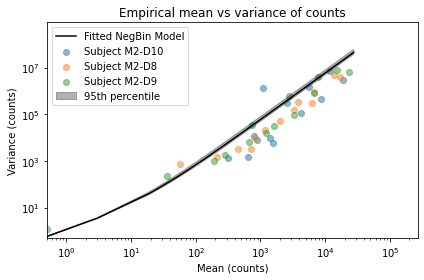

In [14]:
fig = md2.negbin.visualize_learned_negative_binomial_model(mcmc_negbin)
fig.tight_layout()

# Run the model

In [15]:
# Get a0 and a1 from negbin (get the mean of the posterior)
from mdsine2.names import STRNAMES
a0 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A0])['mean']
a1 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A1])['mean']

print('negbin a0', a0)
print('negbin a1', a1)

basepath = 'output/mdsine2/uc0'
os.makedirs(basepath, exist_ok=True)


# Initialize parameters of the model
params = md2.config.MDSINE2ModelConfig(
    basepath=basepath, seed=0, burnin=50, 
    n_samples=100, negbin_a0=a0, negbin_a1=a1, checkpoint=50)

# The default number of modules is 30, which is larger than the number of taxa
# that we have in this dataset, which would throw a flag.
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'

negbin a0 1.1642672989308661e-13
negbin a1 0.05972242507901712


In [16]:
# initilize the graph
mcmc_uc0 = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)


INFO:base.2534: max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
INFO:run.84: Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
INFO:run.251: There are 372 qPCR measurements for 3 buckets. Each bucket is 124 measurements long
INFO:run.286: Initializing Filtering
INFO:posterior.2649: Setting up the essential timepoints
INFO:posterior.2662: Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  62.  63.  64.  64.5]
INFO:run.286: Initializing Zero inflation
INFO:design_matrices.846: Initializing LHS vector
INFO:design_matrices.1011: Initializing growth design matrix
INFO:design_matrices.939: Initializing self-inte

INFO:run.369: 	perturbation High Fat Diet
INFO:run.370: 		value: {2437729496424: 0, 2437729496984: 0, 2437692792904: 0, 2437692793128: 0, 2437692793240: 0, 2437692793352: 0, 2437692793576: 0, 2437692793688: 0, 2437692793912: 0, 2437692794024: 0, 2437692794136: 0, 2437692794248: 0, 2437692794472: 0, 2437692794584: 0, 2437692794696: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Vancomycin
INFO:run.370: 		value: {2437729496424: 0, 2437729496984: 0, 2437692792904: 0, 2437692793128: 0, 2437692793240: 0, 2437692793352: 0, 2437692793576: 0, 2437692793688: 0, 2437692793912: 0, 2437692794024: 0, 2437692794136: 0, 2437692794248: 0, 2437692794472: 0, 2437692794584: 0, 2437692794696: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Gentamicin
INFO:run.370: 		value: {2437729496424: 0, 2437729496984: 0, 2437692792904: 0, 2437692793128: 0, 2437692793240: 0, 2437692793352: 0, 2437692793576: 0, 2437692793688: 0, 2437692793912: 0, 2437692794024: 0, 2437692794136: 0, 243769279424

In [17]:
mcmc_uc0 = md2.run_graph(mcmc_uc0, crash_if_error=True)

INFO:inference.429: 

Inference iteration 0/100, time: 0.0
INFO:inference.438: Cluster interaction indicator parameter: None
INFO:inference.438: Cluster interaction probability: 0.09234190994988938
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: Nones
perturbation High Fat Diet (0/15): [False False False False False False False False False False False False False False False]
perturbation Vancomycin (0/15): [False False False False False False False False False False False False False False False]
perturbation Gentamicin (0/15): [False False False False False False False False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.1527842458791451
	perturbation Vancomycin: 0.1527842458791451
	perturbation Gentamicin: 0.1527842458791451
INFO:inference.438: Logistic growth parameters (growth, se

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 9.483892334955561
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -5.633760869066583
	perturbation Vancomycin: -32.394691549238026
	perturbation Gentamicin: 19.22092898194378
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.155360661555971, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.7886622384767377, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 4047.7156572959684
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 204.06655221025355
	perturbation Vancomycin: 1115.7342315369867
	perturbation Gen

INFO:inference.438: Cluster interaction probability: 0.06389609988570996
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.018030643463134766s
perturbation High Fat Diet (1/15): [False False False False False  True False False False False False False False False False]
perturbation Vancomycin (2/15): [False False False False False False False False  True False False False  True False False]
perturbation Gentamicin (2/15): [False False False False False False False  True False False False False  True False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.025066240399094393
	perturbation Vancomycin: 0.09438846925304158
	perturbation Gentamicin: 0.311140162497224
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.05133125 0.35152011 0.35811711 0.31745151 0.483465

INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 15
Cluster 2437729496424
	members: ['OTU_1']
	size: 1
Cluster 2437729496984
	members: ['OTU_2']
	size: 1
Cluster 2437692792904
	members: ['OTU_3']
	size: 1
Cluster 2437692793128
	members: ['OTU_4']
	size: 1
Cluster 2437692793240
	members: ['OTU_5']
	size: 1
Cluster 2437692793352
	members: ['OTU_6']
	size: 1
Cluster 2437692793576
	members: ['OTU_7']
	size: 1
Cluster 2437692793688
	members: ['OTU_8']
	size: 1
Cluster 2437692793912
	members: ['OTU_9']
	size: 1
Cluster 2437692794024
	members: ['OTU_10']
	size: 1
Cluster 2437692794136
	members: ['OTU_12']
	size: 1
Cluster 2437692794248
	members: ['OTU_13']
	size: 1
Cluster 2437692794472
	members: ['OTU_16']
	size: 1
Cluster 2437692794584
	members: ['OTU_17']
	size: 1
Cluster 2437692794696
	members: ['OTU_18']
	size: 1
no mp - Total time: -1
INFO:inference.438: Clustering concentration parameter: 2548.488953421099
INF

INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.00705142824872686
	perturbation Vancomycin: 0.058009547458432086
	perturbation Gentamicin: 0.010407186256345617
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.33177439 0.23173319 0.56984159 0.06610666 0.73834138 0.37649999 0.17773049 0.33446167 0.08571536 0.04545877 0.34153927 0.08856232 0.79044342 0.1695477  0.12133085]
Self Interactions:
[ 0.23400299  0.14923473  0.17452013  0.50718039  1.21232426  0.21217377  1.10989663  1.31420329 75.42502516 92.74248593  1.70750192 42.6193425   5.18142832  1.74394807  0.91148488]
Interactions:
[13.05797543]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-2.13185033]
	 perturbation Gentamicin: []
INFO:inference.438: Mean parameter for the normal 

INFO:inference.438: Cluster interaction probability: 0.0010390296512950673
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.013019561767578125s
perturbation High Fat Diet (0/13): [False False False False False False False False False False False False False]
perturbation Vancomycin (2/13): [False  True  True False False False False False False False False False False]
perturbation Gentamicin (0/13): [False False False False False False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.005561888958874382
	perturbation Vancomycin: 0.20229856998105772
	perturbation Gentamicin: 0.14193944076812426
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.4475133  0.29674938 0.47790373 0.09309452 0.64502525 0.29222916 0.13538202 0.34951

INFO:inference.438: Clustering concentration parameter: 40.993705508902366
INFO:inference.429: 

Inference iteration 10/100, time: 0.34897422790527344
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False]
total time: 0.03998613357543945, n_interactions: 0/110, 0.00
INFO:inference.438: Cluster interaction probability: 0.0004728646

INFO:inference.438: Clustering concentration parameter: 55.36774573990386
INFO:inference.429: 

Inference iteration 12/100, time: 0.34600281715393066
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False]
total time: 0.042981624603271484, n_interactions: 0/110, 0.00
INFO:inference.438: Cluster interaction probability: 0.0001223248

INFO:inference.438: Process Variance parameter: 4.239563302624807, empirical_variance: 4.26415
INFO:inference.438: Filtering: no-mp - Time: 0.2710, Acc: [0.621, 0.623, 0.608, 0.623, 0.628], data/sec: 20756.61
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 12
Cluster 2437726783304
	members: ['OTU_16', 'OTU_17']
	size: 2
Cluster 2437692722368
	members: ['OTU_12']
	size: 1
Cluster 2437692917912
	members: ['OTU_6']
	size: 1
Cluster 2437693570464
	members: ['OTU_4', 'OTU_7']
	size: 2
Cluster 2437692794696
	members: ['OTU_10']
	size: 1
Cluster 2437724317960
	members: ['OTU_9']
	size: 1
Cluster 2437724317736
	members: ['OTU_3']
	size: 1
Cluster 2437725552536
	members: ['OTU_1']
	size: 1
Cluster 2437692795984
	members: ['OTU_2', 'OTU_18']
	size: 2
Cluster 2437683920792
	members: ['OTU_5']
	size: 1
Cluster 2437724317792
	members: ['OTU_8']
	size: 1
Cluster 2437693570128
	members: ['OTU_13']
	size: 1
no mp - Total tim

INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -199.58795392597125
	perturbation Vancomycin: -11.407335719632053
	perturbation Gentamicin: 107.97323886560982
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.5746660102094945, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.7920112166148252, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 205.9093628514443
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1465.245217177197
	perturbation Vancomycin: 625.8670611855024
	perturbation Gentamicin: 4099.610919576794
INFO:inference.438: Process Variance parameter: 4.084746070731976, empirical_

INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0034763511261976963
	perturbation Vancomycin: 0.20458788682390935
	perturbation Gentamicin: 0.035846352258551366
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.49215013 0.24848084 0.62580469 0.33357661 0.60369627 0.16914551 0.46343851 0.26343532 0.03206933 0.09907179 0.44378578 0.27951419 0.82977597 0.48525938 0.05035364]
Self Interactions:
[  0.34463925   0.22943026   0.27451578  10.7041922    0.45907415   0.38285699   2.65795748   0.65164577  58.39042247 103.67329456   2.23079905  52.55914872   3.83326542   3.57947971   3.67649527]
Interactions:
[]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-3.67824698]
	 perturbation Gentamicin: []
INFO:inference.438: Mean parameter for the no

INFO:inference.438: Cluster interaction probability: 0.025108981939191036
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.008999109268188477s
perturbation High Fat Diet (0/11): [False False False False False False False False False False False]
perturbation Vancomycin (1/11): [ True False False False False False False False False False False]
perturbation Gentamicin (0/11): [False False False False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0002422387718310053
	perturbation Vancomycin: 0.028772728026863058
	perturbation Gentamicin: 0.04369588958817212
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.77846914 0.38349566 0.49872881 0.18203396 0.37550431 0.53301147 0.52731464 0.38844791 0.31131753 0.0072872  0.3556549

INFO:posterior.1569: 10/15: 1
INFO:posterior.1569: 11/15: 6
INFO:posterior.1569: 12/15: 0
INFO:posterior.1569: 13/15: 4
INFO:posterior.1569: 14/15: 10
INFO:inference.429: 

Inference iteration 21/100, time: 0.7459771633148193
INFO:inference.438: Cluster interaction indicator parameter: [False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False]
total time: 0.039000749588012695, n_interactions: 2

INFO:inference.438: Clustering concentration parameter: 7.224679119162434
INFO:inference.429: 

Inference iteration 23/100, time: 0.35303258895874023
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False]
total time: 0.028998851776123047, n_interactions: 2/72, 0.03
INFO:inference.438: Cluster interaction probability: 0.006084782039556326
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.010003328323364258s
perturbation High Fat Diet (0/9): [False False False False False False False False False]
perturbation Vancomyci

INFO:posterior.1569: 0/15: 4
INFO:posterior.1569: 1/15: 9
INFO:posterior.1569: 2/15: 14
INFO:posterior.1569: 3/15: 1
INFO:posterior.1569: 4/15: 13
INFO:posterior.1569: 5/15: 3
INFO:posterior.1569: 6/15: 6
INFO:posterior.1569: 7/15: 0
INFO:posterior.1569: 8/15: 2
INFO:posterior.1569: 9/15: 7
INFO:posterior.1569: 10/15: 8
INFO:posterior.1569: 11/15: 12
INFO:posterior.1569: 12/15: 11
INFO:posterior.1569: 13/15: 5
INFO:posterior.1569: 14/15: 10
INFO:inference.429: 

Inference iteration 25/100, time: 0.6840276718139648
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fals

INFO:inference.438: Clustering concentration parameter: 9.530272183391805
INFO:inference.429: 

Inference iteration 27/100, time: 0.35199928283691406
INFO:inference.438: Cluster interaction indicator parameter: [ True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False]
total time: 0.028004169464111328, n_interactions: 1/72, 0.01
INFO:inference.438: Cluster interaction probability: 0.0258845152210347
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.010010719299316406s
perturbation High Fat Diet (0/9): [False False False False False False False False False]
perturbation Vancomycin 

INFO:posterior.1569: 0/15: 9
INFO:posterior.1569: 1/15: 13
INFO:posterior.1569: 2/15: 4
INFO:posterior.1569: 3/15: 10
INFO:posterior.1569: 4/15: 12
INFO:posterior.1569: 5/15: 2
INFO:posterior.1569: 6/15: 11
INFO:posterior.1569: 7/15: 14
INFO:posterior.1569: 8/15: 8
INFO:posterior.1569: 9/15: 0
INFO:posterior.1569: 10/15: 3
INFO:posterior.1569: 11/15: 7
INFO:posterior.1569: 12/15: 6
INFO:posterior.1569: 13/15: 1
INFO:posterior.1569: 14/15: 5
INFO:inference.429: 

Inference iteration 29/100, time: 0.77095627784729
INFO:inference.438: Cluster interaction indicator parameter: [ True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False 

INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 11
Cluster 2437692917912
	members: ['OTU_6', 'OTU_16', 'OTU_17']
	size: 3
Cluster 2437686763304
	members: ['OTU_5', 'OTU_8']
	size: 2
Cluster 2437726360240
	members: ['OTU_7', 'OTU_10']
	size: 2
Cluster 2437689212208
	members: ['OTU_12']
	size: 1
Cluster 2437721779896
	members: ['OTU_3']
	size: 1
Cluster 2437670643416
	members: ['OTU_13']
	size: 1
Cluster 2437692796152
	members: ['OTU_18']
	size: 1
Cluster 2437693570128
	members: ['OTU_9']
	size: 1
Cluster 2437721779000
	members: ['OTU_1']
	size: 1
Cluster 2437726693304
	members: ['OTU_4']
	size: 1
Cluster 2437726694256
	members: ['OTU_2']
	size: 1
no mp - Total time: 0.4269890785217285
INFO:inference.438: Clustering concentration parameter: 20.860006416989954
INFO:inference.429: 

Inference iteration 31/100, time: 0.36602783203125
INFO:inference.438: Cluster interaction indicator parameter: [ True False  True F

INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 15.731604802811969
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1809.7879451435756
	perturbation Vancomycin: 4030.7110708995715
	perturbation Gentamicin: 1515.846393991173
INFO:inference.438: Process Variance parameter: 3.4157879711116084, empirical_variance: 3.43095
INFO:inference.438: Filtering: no-mp - Time: 0.2770, Acc: [0.646, 0.614, 0.628, 0.615, 0.610], data/sec: 20306.81
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 11
Cluster 2437692917912
	members: ['OTU_6', 'OTU_16', 'OTU_17']
	size: 3
Cluster 2437686763304
	members: ['OTU_5', 'OTU_8']
	size: 2
Cluster 2437726360240
	members: ['OTU_7', 'OTU_10']
	size: 2
Cluster 2437689212208
	members: ['OTU_12']
	size: 1
Cluster 2437721779896
	members: ['OTU_3']

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 0.11346456742536248
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -287.2636460323993
	perturbation Vancomycin: -15.966582717209585
	perturbation Gentamicin: -44.51941416792625
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.8063173199661877, Acceptance rate: 0.9705882352941176
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.5098456352896183, Acceptance rate: 0.9705882352941176
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 38.79008578447357
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2504.7403119291275
	perturbation Vancomycin: 101

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -11.947206324046372
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 76.20880887530345
	perturbation Vancomycin: 6.6406071952773695
	perturbation Gentamicin: -30.54905939731654
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.480112869625481, Acceptance rate: 0.9722222222222222
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.6923877903636977, Acceptance rate: 0.9722222222222222
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 100.14308502493722
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3047.4181553078524
	perturbation Vancomycin: 512.1

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -6.81984828775422
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -21.28227680114335
	perturbation Vancomycin: -5.838041063829582
	perturbation Gentamicin: -14.603074897369472
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.1455061558991604, Acceptance rate: 0.9736842105263158
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.3384004180329474, Acceptance rate: 0.9736842105263158
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 559.4148970617318
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3762.028345345361
	perturbation Vancomycin: 2436.5

INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 15.155271979332618
	perturbation Vancomycin: 44.92503251639171
	perturbation Gentamicin: -170.09836459177137
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.8335070824182024, Acceptance rate: 0.975
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.384621343304751, Acceptance rate: 0.975
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 487.320017466133
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1057.1351321334848
	perturbation Vancomycin: 3762.203439693238
	perturbation Gentamicin: 4915.003573710654
INFO:inference.438: Process Variance parameter: 3.1441953590501233, empirica

INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.66626479 0.30463533 0.29983638 0.06835762 0.62418535 0.89990445 0.38584266 0.43940033 0.27304697 0.09019083 0.41600894 0.27877548 1.09639478 0.99039015 0.31489288]
Self Interactions:
[4.51519211e-01 1.94331513e-01 1.97321857e-01 3.17790022e+00 1.22707208e+00 6.13916217e-01 2.35970860e+00 1.38555171e+00 1.71091734e+02 2.72696219e+02 2.10355549e+00 1.27602770e+02 2.68757028e+00 3.32857339e+00 4.15865597e+00]
Interactions:
[ -0.15937604 -20.74794878 -12.36035387 -30.04519646]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: [1.7921168]
	 perturbation Vancomycin: [-1.21652528]
	 perturbation Gentamicin: []
INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -22.791395833188645
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbat

INFO:inference.438: Cluster interaction probability: 0.00831210316885257
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.010970830917358398s
perturbation High Fat Diet (0/11): [False False False False False False False False False False False]
perturbation Vancomycin (1/11): [ True False False False False False False False False False False]
perturbation Gentamicin (0/11): [False False False False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.005352728845383294
	perturbation Vancomycin: 0.042351156798518745
	perturbation Gentamicin: 0.0011686009112365505
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.77724478 0.35711583 0.54278462 0.14395634 0.5829865  0.92285704 0.41231317 0.37109848 0.26664438 0.18550337 0.3799004

INFO:inference.438: Clustering concentration parameter: 3.8463934854208786
INFO:inference.429: 

Inference iteration 46/100, time: 0.3599889278411865
INFO:inference.438: Cluster interaction indicator parameter: [ True False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False]
total time: 0.030995845794677734, n_interactions: 3/72, 0.04
INFO:inference.438: Cluster interaction probability: 0.028050982595124514
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.013001441955566406s
perturbation High Fat Diet (0/9): [False False False False False False False False False]
perturbation Vancomyci

INFO:inference.438: Clustering concentration parameter: 15.355466727434358
INFO:inference.429: 

Inference iteration 48/100, time: 0.35202479362487793
INFO:inference.438: Cluster interaction indicator parameter: [ True False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False  True False False False False False False False False]
total time: 0.028001070022583008, n_interactions: 4/72, 0.06
INFO:inference.438: Cluster interaction probability: 0.036460676857281306
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.01000070571899414s
perturbation High Fat Diet (0/9): [False False False False False False False False False]
perturbation Vancomyci

INFO:inference.438: Clustering concentration parameter: 2.7957244807090866
INFO:inference.429: 

Inference iteration 50/100, time: 0.48597216606140137
INFO:inference.438: Cluster interaction indicator parameter: [ True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False]
total time: 0.01802515983581543, n_interactions: 1/42, 0.02
INFO:inference.438: Cluster interaction probability: 0.07268906859771236
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.009998083114624023s
perturbation High Fat Diet (0/7): [False False False False False False False]
perturbation Vancomycin (1/7): [ True False False False False False False]
perturbation Gentamicin (0/7): [False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of t

INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 2.545620533640056e-06
	perturbation Vancomycin: 0.07385378528429888
	perturbation Gentamicin: 0.1229562234109409
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.82129339 0.51483576 0.56391375 0.12306453 0.59674969 0.65795775 0.52300014 0.42553626 0.34565678 0.13269213 0.56233797 0.21444693 1.07779323 1.18817862 0.59478485]
Self Interactions:
[4.70156738e-01 2.34348868e-01 2.11469860e-01 3.75392732e+00 1.51502345e+00 2.91310272e-01 5.93337247e-01 1.27315706e+00 1.60917195e+02 2.65856494e+02 2.83562333e+00 9.60428818e+01 4.46742069e+00 5.52562565e+00 6.67854720e-01]
Interactions:
[-0.1553745]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-0.92781414]
	 perturbation Gentamicin: []
INFO:in

INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.83228575 0.35439474 0.72857496 0.22317631 0.7486385  0.65793358 0.55935548 0.50365616 0.17287309 0.08750253 0.47051025 0.3541198  1.21042596 1.00481002 0.38605613]
Self Interactions:
[4.75900752e-01 1.73835053e-01 2.18182564e-01 2.05125814e+00 1.59919324e+00 4.80911857e-01 5.85486779e-01 1.31737609e+00 1.56009791e+02 2.68748105e+02 2.37096996e+00 1.27987127e+02 2.99689006e+00 4.24073840e+00 1.44287738e+00]
Interactions:
[ -0.14854678 -27.89301377  -5.29880339 -50.95645776 -13.73350409]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.25152933]
	 perturbation Gentamicin: [-1.43486247]
INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -25.874089940860287
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior M

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -22.979874257289573
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 48.03012611152859
	perturbation Vancomycin: -53.47378394849372
	perturbation Gentamicin: -50.26520121262516
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.5147636135260056, Acceptance rate: 0.98
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.0211510183699464, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 750.4499632119376
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4084.574806190417
	perturbation Vancomycin: 12735.736667679623
	perturbation G

INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.5584670040801312, Acceptance rate: 0.98
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.2393558709393857, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 871.1358156835147
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2380.2561574142646
	perturbation Vancomycin: 5755.254793849883
	perturbation Gentamicin: 1589.7111029736145
INFO:inference.438: Process Variance parameter: 2.6873336420989427, empirical_variance: 2.64476
INFO:inference.438: Filtering: no-mp - Time: 0.2730, Acc: [0.636, 0.608, 0.618, 0.592, 0.617], data/sec: 20604.90
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters:

INFO:inference.438: Clustering concentration parameter: 3.3275086145914137
INFO:posterior.1569: 0/15: 11
INFO:posterior.1569: 1/15: 13
INFO:posterior.1569: 2/15: 14
INFO:posterior.1569: 3/15: 7
INFO:posterior.1569: 4/15: 12
INFO:posterior.1569: 5/15: 2
INFO:posterior.1569: 6/15: 6
INFO:posterior.1569: 7/15: 9
INFO:posterior.1569: 8/15: 5
INFO:posterior.1569: 9/15: 1
INFO:posterior.1569: 10/15: 10
INFO:posterior.1569: 11/15: 3
INFO:posterior.1569: 12/15: 8
INFO:posterior.1569: 13/15: 0
INFO:posterior.1569: 14/15: 4
INFO:inference.429: 

Inference iteration 61/100, time: 0.6069741249084473
INFO:inference.438: Cluster interaction indicator parameter: [ True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False]
total time: 0.01697564125061035, n_interactions: 1/30, 0.03
INFO:inference.438: Cluster interaction probability: 0.03489080558549836
INFO:inference.438: Perturbat

INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.04540806758437727
	perturbation Vancomycin: 0.255029535980409
	perturbation Gentamicin: 0.20508638690497277
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.40710599 0.47798884 0.7281876  0.10907598 0.6494994  0.65236158 0.7081923  0.67165173 0.17986395 0.2695581  0.55133542 0.19992098 1.10430756 0.9263828  0.49811036]
Self Interactions:
[  0.38974056   0.28990653   0.28620734   4.91073953   0.99639482   0.36367374   0.26635114   1.61497751 251.27097004 238.15447763   3.14833292 131.81417747   2.96690989   2.06094679   0.73707136]
Interactions:
[-0.14634864]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.15230392]
	 perturbation Gentamicin: [-1.34076049]
INFO:inference.438: Mean par

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 3.274945093441633
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -19.668941331277644
	perturbation Vancomycin: -42.670202573533594
	perturbation Gentamicin: -15.323148086651184
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.6588930250892864, Acceptance rate: 0.98
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.4346001002976476, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 55.46317788341618
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1960.9310643566857
	perturbation Vancomycin: 1333.9341871665183
	perturbatio

INFO:inference.438: Clustering concentration parameter: 1.6615245980627562
INFO:inference.429: 

Inference iteration 68/100, time: 0.33499908447265625
INFO:inference.438: Cluster interaction indicator parameter: [ True False False False False False False False False False False False]
total time: 0.010998964309692383, n_interactions: 1/12, 0.08
INFO:inference.438: Cluster interaction probability: 0.06327972651849974
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.006969928741455078s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (1/4): [ True False False False]
perturbation Gentamicin (1/4): [False False  True False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0009700047278280243
	perturbation Vancomycin: 0.44730320846956484
	perturbation Gentamicin: 0.17961703500797865
INFO:inference.4

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 7.809960528742605
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 43.27364399569105
	perturbation Vancomycin: 16.66519474467598
	perturbation Gentamicin: 92.24451410647185
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.3239183188399017, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.3592432444609788, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 96.47662909420373
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4250.625809109822
	perturbation Vancomycin: 4828.238392074598
	perturbation Gentamic

INFO:inference.438: Clustering concentration parameter: 0.7047074853116073
INFO:posterior.1569: 0/15: 6
INFO:posterior.1569: 1/15: 8
INFO:posterior.1569: 2/15: 0
INFO:posterior.1569: 3/15: 12
INFO:posterior.1569: 4/15: 4
INFO:posterior.1569: 5/15: 5
INFO:posterior.1569: 6/15: 11
INFO:posterior.1569: 7/15: 3
INFO:posterior.1569: 8/15: 14
INFO:posterior.1569: 9/15: 2
INFO:posterior.1569: 10/15: 13
INFO:posterior.1569: 11/15: 9
INFO:posterior.1569: 12/15: 7
INFO:posterior.1569: 13/15: 10
INFO:posterior.1569: 14/15: 1
INFO:inference.429: 

Inference iteration 73/100, time: 0.4929802417755127
INFO:inference.438: Cluster interaction indicator parameter: [ True False False False False False]
total time: 0.008020877838134766, n_interactions: 1/6, 0.17
INFO:inference.438: Cluster interaction probability: 0.2284804378353666
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.005004405975341797s
perturbation High Fat Diet (0/3): [False False False]
perturbation

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 3.0780272978595957
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -33.498430161327924
	perturbation Vancomycin: -15.208701197153891
	perturbation Gentamicin: -50.69128093342633
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.5674683309706121, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.7818370090447382, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 24.15255662678458
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1855.7454856721783
	perturbation Vancomycin: 4880.254290481497
	perturbation G

INFO:inference.438: Filtering: no-mp - Time: 0.2660, Acc: [0.617, 0.603, 0.621, 0.606, 0.636], data/sec: 21146.92
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 2437692917912
	members: ['OTU_7', 'OTU_6', 'OTU_18', 'OTU_17', 'OTU_16']
	size: 5
Cluster 2437686763304
	members: ['OTU_5', 'OTU_1', 'OTU_9', 'OTU_2', 'OTU_12', 'OTU_4']
	size: 6
Cluster 2437692793912
	members: ['OTU_8', 'OTU_10', 'OTU_3']
	size: 3
Cluster 2437721535768
	members: ['OTU_13']
	size: 1
no mp - Total time: 0.16496896743774414
INFO:inference.438: Clustering concentration parameter: 0.6883655244238756
INFO:inference.429: 

Inference iteration 78/100, time: 0.3240046501159668
INFO:inference.438: Cluster interaction indicator parameter: [ True False False False False False False False False False False False]
total time: 0.009999275207519531, n_interactions: 1/12, 0.08
INFO:inference.438: Cluster interaction probability: 0.09562901

INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.60950346 0.46392332 0.31797955 0.0419076  0.61817006 0.7486636  0.73377365 0.37058437 0.4037117  0.09703448 0.4615001  0.36522066 1.04139989 1.14769689 0.575919  ]
Self Interactions:
[4.52532710e-01 2.96459849e-01 1.61748550e-01 7.57462887e+00 1.13711190e+00 3.58245618e-01 8.79310842e-01 1.30000445e+00 2.54431306e+02 2.61574438e+02 2.55204945e+00 2.42582810e+02 2.65600394e+00 5.01513316e+00 1.43429651e+00]
Interactions:
[-0.13771489]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.0309924]
	 perturbation Gentamicin: [-2.47139699]
INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 0.37987835892296445
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 140.9980256243392
	p

INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 127.60379051326439
	perturbation Vancomycin: -20.416964358498273
	perturbation Gentamicin: 68.09125390659874
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.0364352241599422, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.2834482505691422, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 101.2978398774141
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2908.607580467104
	perturbation Vancomycin: 19691.262578342714
	perturbation Gentamicin: 3692.617865532299
INFO:inference.438: Process Variance parameter: 2.5135988617892693, empirical_

INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 2437692917912
	members: ['OTU_7', 'OTU_6', 'OTU_18', 'OTU_17', 'OTU_16']
	size: 5
Cluster 2437686763304
	members: ['OTU_1', 'OTU_2', 'OTU_9', 'OTU_12', 'OTU_13']
	size: 5
Cluster 2437692793912
	members: ['OTU_8', 'OTU_10', 'OTU_3']
	size: 3
Cluster 2437721535768
	members: ['OTU_4']
	size: 1
Cluster 2437726691512
	members: ['OTU_5']
	size: 1
no mp - Total time: 0.21698951721191406
INFO:inference.438: Clustering concentration parameter: 0.961730472908293
INFO:posterior.1569: 0/15: 11
INFO:posterior.1569: 1/15: 13
INFO:posterior.1569: 2/15: 2
INFO:posterior.1569: 3/15: 7
INFO:posterior.1569: 4/15: 3
INFO:posterior.1569: 5/15: 8
INFO:posterior.1569: 6/15: 5
INFO:posterior.1569: 7/15: 14
INFO:posterior.1569: 8/15: 10
INFO:posterior.1569: 9/15: 1
INFO:posterior.1569: 10/15: 9
INFO:posterior.1569: 11/15: 4
INFO:posterior.1569: 12/15: 12
INFO:posterior.1569: 1

INFO:inference.438: Cluster interaction probability: 0.154589020835998
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.007006168365478516s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (1/4): [ True False False False]
perturbation Gentamicin (1/4): [False False  True False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.005520310574447161
	perturbation Vancomycin: 0.41461736102569696
	perturbation Gentamicin: 0.34443322503735585
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.6083802  0.38082322 0.58011794 0.13554762 0.52142723 0.67327475 0.67081847 0.39978393 0.19461456 0.25814806 0.5537697  0.41402645 1.11337254 0.94883755 0.49519773]
Self Interactions:
[4.18153454e-01 2.84626773e-01 1.61722344e-01 5.16366173e+00 1.02310

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -21.8590698480119
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 152.90785506972705
	perturbation Vancomycin: 3.750282994092409
	perturbation Gentamicin: 118.76543947278644
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.39915674036450954, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.2469879661088816, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 174.68006309320606
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2094.351652293412
	perturbation Vancomycin: 3437.6595933322365
	perturbation Gen

INFO:inference.438: Clustering concentration parameter: 1.0124896147989084
INFO:inference.429: 

Inference iteration 92/100, time: 0.3209667205810547
INFO:inference.438: Cluster interaction indicator parameter: [ True False False False False False False False False False False False]
total time: 0.009027719497680664, n_interactions: 1/12, 0.08
INFO:inference.438: Cluster interaction probability: 0.05641377130976999
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.005998849868774414s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (1/4): [ True False False False]
perturbation Gentamicin (2/4): [ True False  True False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.02586782955110929
	perturbation Vancomycin: 0.0874312203751395
	perturbation Gentamicin: 0.4507996006362527
INFO:inference.438: L

INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.62539051 0.62591267 0.53930864 0.09297927 0.58726795 0.90503944 0.76737264 0.44312061 0.15819521 0.06460252 0.67521889 0.34081271 1.13472246 0.92729035 0.81410656]
Self Interactions:
[3.64806405e-01 3.94215103e-01 2.48969175e-01 9.25875227e+00 1.06466342e+00 4.11315491e-01 2.15854642e-01 8.97665887e-01 2.14572410e+02 2.28293906e+02 3.32778435e+00 1.75893676e+02 2.39466515e+00 2.90828347e+00 2.19274194e+00]
Interactions:
[-0.16979865]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-0.98821538]
	 perturbation Gentamicin: [-0.78810024 -1.47974179]
INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 17.747762019520213
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 33.42894

INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.5365396403629976, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 121.95631348482681
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2467.454297011208
	perturbation Vancomycin: 5893.074073283528
	perturbation Gentamicin: 2604.5658912865138
INFO:inference.438: Process Variance parameter: 2.375204067976565, empirical_variance: 2.38023
INFO:inference.438: Filtering: no-mp - Time: 0.2800, Acc: [0.620, 0.617, 0.595, 0.588, 0.627], data/sec: 20089.00
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 2437692917912
	members: ['OTU_7', 'OTU_6', 'OTU_18', 'OTU_17', 'OTU_16']
	size: 5
Cluster 2437686763304
	members: ['OTU_4', 'OTU_9'

INFO:inference.438: Clustering concentration parameter: 0.1778946407526882
INFO:inference.429: 

Inference iteration 99/100, time: 0.31899404525756836
INFO:inference.438: Cluster interaction indicator parameter: [ True False False False False  True False False False False False False]
total time: 0.010031461715698242, n_interactions: 2/12, 0.17
INFO:inference.438: Cluster interaction probability: 0.09734033067166288
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.0069997310638427734s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (1/4): [ True False False False]
perturbation Gentamicin (1/4): [False False  True False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0036554976603672073
	perturbation Vancomycin: 0.23915567319693598
	perturbation Gentamicin: 0.04474108637941594
INFO:inference.

INFO:util.171: Number of clusters: 4
INFO:util.177: Clusters assigned: [0 0 2 3 0 1 1 2 0 2 0 0 1 1 1]


Cluster 0
	 * Bacteroides OTU_4
Cluster 1
	 * Phocaeicola OTU_1
	 Bacteroides fragilis/ovatus OTU_2
	 Parasutterella excrementihominis OTU_5
	 * Bacteroides OTU_9
	 Parabacteroides distasonis OTU_12
	 Parabacteroides goldsteinii OTU_13
Cluster 2
	 Bacteroides fragilis/dorei OTU_6
	 Bacteroides caccae OTU_7
	 * Enterocloster OTU_16
	 Murimonas intestini OTU_17
	 Parabacteroides merdae OTU_18
Cluster 3
	 Bacteroides uniformis OTU_10
	 Akkermansia muciniphila OTU_3
	 Bacteroides salyersiae OTU_8


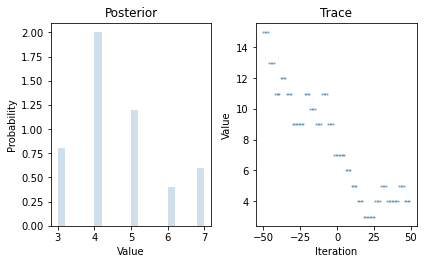

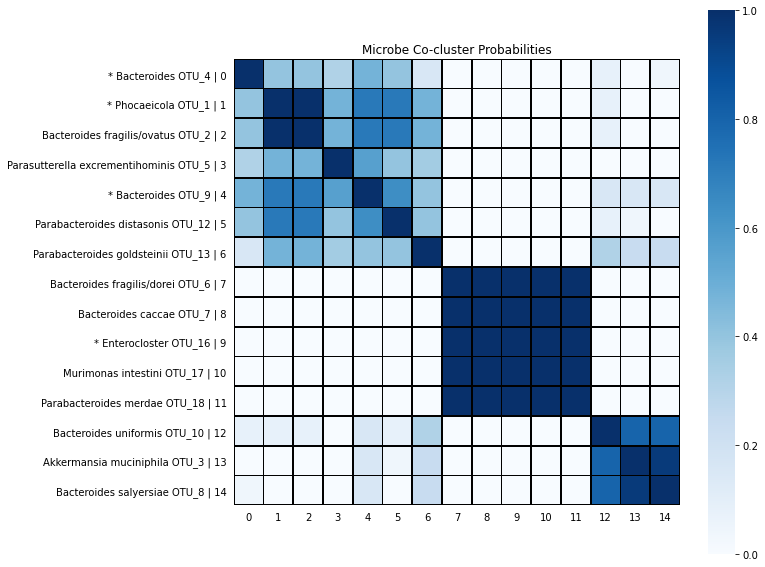

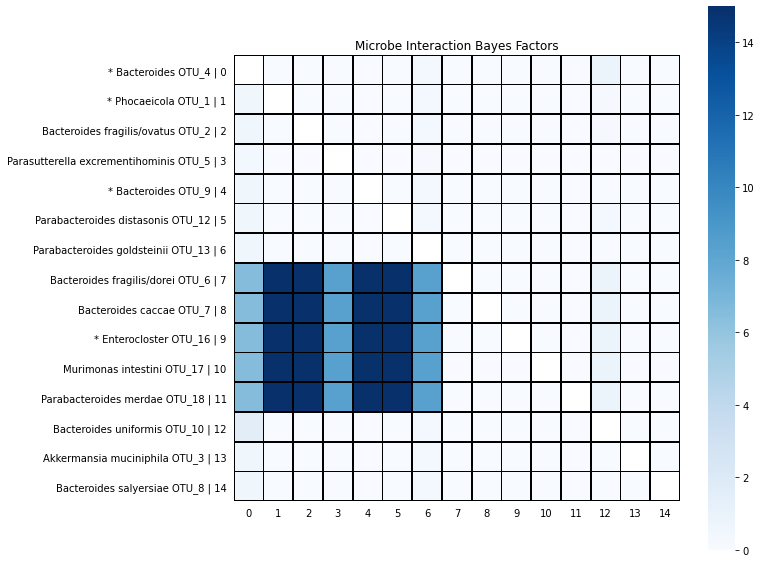

In [18]:
clustering = mcmc_uc0.graph[STRNAMES.CLUSTERING_OBJ]
md2.generate_cluster_assignments_posthoc(clustering, set_as_value=True)
taxas = mcmc_uc0.graph.data.taxas

md2.visualization.render_trace(clustering.n_clusters)
order = []
for i, cluster in enumerate(clustering):
    print('Cluster {}'.format(i))
    for oidx in cluster:
        print('\t', md2.taxaname_for_paper(taxas[oidx], taxas))
        order.append(oidx)

coclusters = md2.summary(mcmc_uc0.graph[STRNAMES.CLUSTERING_OBJ].coclusters)['mean']
md2.visualization.render_cocluster_proportions(coclusters, taxas=uc_toy.taxas,
    yticklabels='%(paperformat)s | %(index)s', order=order)

bayes_factors = md2.generate_interation_bayes_factors_posthoc(mcmc_uc0)
md2.visualization.render_bayes_factors(
    bayes_factors, taxas=taxas, yticklabels='%(paperformat)s | %(index)s',
    order=order)
plt.show()

# Calculating  $\hat{r}$

In [19]:
params = md2.config.MDSINE2ModelConfig(
    basepath='output/mdsine2/uc100', seed=100, burnin=50, 
    n_samples=100, negbin_a0=a0, negbin_a1=a1, 
    checkpoint=50)
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'
mcmc_uc1 = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)
mcmc_uc1 = md2.run_graph(mcmc_uc1, crash_if_error=True)


INFO:base.2534: max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
INFO:run.84: Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
INFO:run.251: There are 372 qPCR measurements for 3 buckets. Each bucket is 124 measurements long
INFO:run.286: Initializing Filtering
INFO:posterior.2649: Setting up the essential timepoints
INFO:posterior.2662: Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  62.  63.  64.  64.5]
INFO:run.286: Initializing Zero inflation
INFO:design_matrices.846: Initializing LHS vector
INFO:design_matrices.1011: Initializing growth design matrix
INFO:design_matrices.939: Initializing self-inte

INFO:run.369: 	perturbation High Fat Diet
INFO:run.370: 		value: {2437693646440: 0, 2437692552248: 0, 2437685512120: 0, 2437692754632: 0, 2437693538824: 0, 2437691134584: 0, 2437727835528: 0, 2437680325632: 0, 2437731263096: 0, 2437731265056: 0, 2437687804032: 0, 2437687804256: 0, 2437687804704: 0, 2437687804816: 0, 2437687804872: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Vancomycin
INFO:run.370: 		value: {2437693646440: 0, 2437692552248: 0, 2437685512120: 0, 2437692754632: 0, 2437693538824: 0, 2437691134584: 0, 2437727835528: 0, 2437680325632: 0, 2437731263096: 0, 2437731265056: 0, 2437687804032: 0, 2437687804256: 0, 2437687804704: 0, 2437687804816: 0, 2437687804872: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Gentamicin
INFO:run.370: 		value: {2437693646440: 0, 2437692552248: 0, 2437685512120: 0, 2437692754632: 0, 2437693538824: 0, 2437691134584: 0, 2437727835528: 0, 2437680325632: 0, 2437731263096: 0, 2437731265056: 0, 2437687804032: 0, 243768780425

INFO:inference.438: Cluster interaction probability: 0.6902120211131538
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.027000904083251953s
perturbation High Fat Diet (9/15): [ True  True False  True False  True False  True  True  True False  True  True False False]
perturbation Vancomycin (11/15): [False  True False  True  True  True  True  True  True False  True False  True  True  True]
perturbation Gentamicin (11/15): [False  True  True False  True False False  True  True  True  True  True  True  True  True]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.543380172150942
	perturbation Vancomycin: 0.6541798484844479
	perturbation Gentamicin: 0.5771423101278725
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.12171643 0.39229091 0.74647098 0.36933789 0.76639724

INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.24935488589151739
	perturbation Vancomycin: 0.39478510894188606
	perturbation Gentamicin: 0.0836243339418902
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.02026563 0.20128539 0.7419323  0.02047319 0.73338937 0.55885879 0.23532478 0.36486274 0.17748172 0.30274626 0.0431157  0.29107326 1.28805679 0.72884907 0.17401487]
Self Interactions:
[9.18655524e-02 1.38047429e-01 2.27791916e-01 1.17697157e+00 1.51039381e+00 4.71091481e-01 2.61297844e-01 8.71438273e-01 6.35525406e+01 1.20543130e+02 1.51028935e-01 1.08117117e+02 4.55128167e+00 1.40742205e+00 4.37614901e+00]
Interactions:
[-9.32740112e+00  4.58207766e+01  6.39503961e-01 -3.69532773e+01 -3.87413142e+01 -6.39760566e-01  4.71188349e+00  1.06267818e+00  4.21912719e+00 -4.41174488e+01  9.84841289e-02 -4.64

INFO:inference.438: Process Variance parameter: 4.657837695315136, empirical_variance: 4.58982
INFO:inference.438: Filtering: no-mp - Time: 0.2815, Acc: [0.627, 0.596, 0.604, 0.618, 0.609], data/sec: 19979.24
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 15
Cluster 2437693646440
	members: ['OTU_1']
	size: 1
Cluster 2437692552248
	members: ['OTU_2']
	size: 1
Cluster 2437685512120
	members: ['OTU_3']
	size: 1
Cluster 2437692754632
	members: ['OTU_4']
	size: 1
Cluster 2437693538824
	members: ['OTU_5']
	size: 1
Cluster 2437691134584
	members: ['OTU_6']
	size: 1
Cluster 2437727835528
	members: ['OTU_7']
	size: 1
Cluster 2437680325632
	members: ['OTU_8']
	size: 1
Cluster 2437731263096
	members: ['OTU_9']
	size: 1
Cluster 2437731265056
	members: ['OTU_10']
	size: 1
Cluster 2437687804032
	members: ['OTU_12']
	size: 1
Cluster 2437687804256
	members: ['OTU_13']
	size: 1
Cluster 2437687804704
	members: ['OTU_16']
	siz

INFO:inference.438: Cluster interaction probability: 0.05671825787353486
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.015027046203613281s
perturbation High Fat Diet (0/13): [False False False False False False False False False False False False False]
perturbation Vancomycin (2/13): [False False False False False  True False False False False False False  True]
perturbation Gentamicin (1/13): [False False False False False  True False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.08997769129193614
	perturbation Vancomycin: 0.10182442866807949
	perturbation Gentamicin: 0.13546862620523445
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.23396469 0.05071815 0.56351721 0.05928085 0.59848133 0.81233107 0.36520648 0.25017111

INFO:inference.438: Clustering concentration parameter: 1970.940896675702
INFO:inference.429: 

Inference iteration 7/100, time: 0.37203049659729004
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False  True False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True Fal

INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 23.568446778338853
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2068.46141497075
	perturbation Vancomycin: 2138.2992494015825
	perturbation Gentamicin: 3113.41801981987
INFO:inference.438: Process Variance parameter: 4.591669162640238, empirical_variance: 4.47048
INFO:inference.438: Filtering: no-mp - Time: 0.2670, Acc: [0.621, 0.621, 0.612, 0.608, 0.588], data/sec: 21069.30
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 13
Cluster 2437692552248
	members: ['OTU_2']
	size: 1
Cluster 2437693840744
	members: ['OTU_8']
	size: 1
Cluster 2437693864368
	members: ['OTU_12']
	size: 1
Cluster 2437730853664
	members: ['OTU_4']
	size: 1
Cluster 2437692754632
	members: ['OTU_6']
	size: 1
Cluster 2437685820216
	members: [

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -6.368735963046126
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -132.58827425550527
	perturbation Vancomycin: 66.65167848784232
	perturbation Gentamicin: -108.33366327777969
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.4674629129828044, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.6544758650501115, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 354.6140980686038
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1954.5486287321498
	perturbation Vancomycin: 69377.49001027018
	perturbation Ge

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 9.088280234819837
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -65.4692636755461
	perturbation Vancomycin: -32.28300697771348
	perturbation Gentamicin: 118.37501847161842
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.6339272417830006, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.14485383749854092, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 20.917720692170512
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3519.426410317728
	perturbation Vancomycin: 1277.7475308193189
	perturbation Gen

INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.004356516856466666
	perturbation Vancomycin: 0.12381213679379392
	perturbation Gentamicin: 0.020395336750981354
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.52410279 0.37362165 0.22060275 0.11288069 0.79311114 0.63906919 0.14857646 0.13468524 0.0340842  0.07038615 0.35997842 0.14966982 0.91657913 0.4615342  0.19671135]
Self Interactions:
[  0.36263944   0.27991095   0.1896172    1.80519132   1.27458572   0.31217063   1.34347789   1.11548809 127.3522612  168.91327496   2.18289651  45.16968625   3.97990058   3.3884882    3.95900407]
Interactions:
[-0.12263424 -0.22494426 -8.72850182]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.58013469]
	 perturbation Gentamicin: []
INFO:infere

INFO:inference.438: Cluster interaction probability: 0.01890427590096804
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.011032342910766602s
perturbation High Fat Diet (0/12): [False False False False False False False False False False False False]
perturbation Vancomycin (1/12): [ True False False False False False False False False False False False]
perturbation Gentamicin (0/12): [False False False False False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.02146420629918015
	perturbation Vancomycin: 0.0401084029810172
	perturbation Gentamicin: 0.02376682179432348
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.63743813 0.49597134 0.52377816 0.14701256 0.62601597 0.4097952  0.30548297 0.25343894 0.05407482 0.07709

INFO:inference.438: Clustering concentration parameter: 11.981200206380256
INFO:inference.429: 

Inference iteration 18/100, time: 0.36925339698791504
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False]
total time: 0.0332646369934082, n_interactions: 1/90, 0.01
INFO:inference.438: Cluster interaction probability: 0.014392389889174021
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.010983705520629883s
pertu

INFO:inference.438: Clustering concentration parameter: 14.856412297473558
INFO:inference.429: 

Inference iteration 20/100, time: 0.3665580749511719
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False]
total time: 0.03798675537109375, n_interactions: 2/90, 0.02
INFO:inference.438: Cluster interaction probability: 0.02591582648732051
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.010019779205322266s
pertur

INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 8
Cluster 2437685820216
	members: ['OTU_6', 'OTU_7', 'OTU_18', 'OTU_16', 'OTU_17']
	size: 5
Cluster 2437731390968
	members: ['OTU_9']
	size: 1
Cluster 2437692762992
	members: ['OTU_8']
	size: 1
Cluster 2437695267392
	members: ['OTU_3']
	size: 1
Cluster 2437724446112
	members: ['OTU_4', 'OTU_5']
	size: 2
Cluster 2437727227408
	members: ['OTU_2', 'OTU_12', 'OTU_13']
	size: 3
Cluster 2437727835528
	members: ['OTU_10']
	size: 1
Cluster 2437723860496
	members: ['OTU_1']
	size: 1
no mp - Total time: 0.3929727077484131
INFO:inference.438: Clustering concentration parameter: 4.578997349757421
INFO:inference.429: 

Inference iteration 22/100, time: 0.33297300338745117
INFO:inference.438: Cluster interaction indicator parameter: [False False False  True False False False False False False False False False False False False False False False False False False False False 

INFO:inference.438: Clustering concentration parameter: 3.472389376442361
INFO:inference.429: 

Inference iteration 24/100, time: 0.3310396671295166
INFO:inference.438: Cluster interaction indicator parameter: [False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False]
total time: 0.023013591766357422, n_interactions: 2/56, 0.04
INFO:inference.438: Cluster interaction probability: 0.0537359499450341
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.008996009826660156s
perturbation High Fat Diet (0/8): [False False False False False False False False]
perturbation Vancomycin (1/8): [ True False False False False False False False]
perturbation Gentamicin (0/8): [False False Fa

INFO:inference.438: Clustering concentration parameter: 12.804433504172525
INFO:inference.429: 

Inference iteration 26/100, time: 0.34299778938293457
INFO:inference.438: Cluster interaction indicator parameter: [ True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False]
total time: 0.021999835968017578, n_interactions: 1/56, 0.02
INFO:inference.438: Cluster interaction probability: 0.00785344723066909
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.007024526596069336s
perturbation High Fat Diet (0/8): [False False False False False False False False]
perturbation Vancomycin (1/8): [ True False False False False False False False]
perturbation Gentamicin (0/8): [False False

INFO:inference.438: Cluster interaction probability: 0.03363004193247114
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.006966829299926758s
perturbation High Fat Diet (0/8): [False False False False False False False False]
perturbation Vancomycin (1/8): [ True False False False False False False False]
perturbation Gentamicin (0/8): [False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0683937456031799
	perturbation Vancomycin: 0.24543602945024506
	perturbation Gentamicin: 0.09102394996916374
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.58320547 0.6021602  0.39691742 0.1292851  0.90204586 0.77785033 0.22934124 0.51420545 0.15252866 0.01200521 0.55511742 0.14177563 1.06470426 0.86788776 0.52037925]
Self Interactio

INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.019915012448276957
	perturbation Vancomycin: 0.1956149138697591
	perturbation Gentamicin: 0.026462672110078862
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.61683424 0.45523198 0.55168862 0.1343103  0.55814074 0.59450771 0.38576357 0.27909936 0.05289001 0.07280302 0.5275686  0.04955586 0.86113586 0.89538969 0.42062838]
Self Interactions:
[  0.38779843   0.20665541   0.26129336   5.08182315   1.05741264   0.5519978    1.15536321   1.2861959  126.48692877 168.2316293    2.4265184   59.03895819   3.27719237   5.77333479   0.89562268]
Interactions:
[-0.21515082  0.10099295]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.26309771]
	 perturbation Gentamicin: []
INFO:inference.438: Mean

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 7.539507787411596
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 197.907840773686
	perturbation Vancomycin: -54.495030265491614
	perturbation Gentamicin: 139.32616076244588
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.236403485600319, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.6951705822208702, Acceptance rate: 0.96875
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 91.63054792762307
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 7189.690441010124
	perturbation Vancomycin: 17075.116583691084
	perturbation Ge

INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 141.83496939355277
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2725.0165466698204
	perturbation Vancomycin: 10259.171097567025
	perturbation Gentamicin: 20778.40356533786
INFO:inference.438: Process Variance parameter: 3.444690786446011, empirical_variance: 3.43659
INFO:inference.438: Filtering: no-mp - Time: 0.2900, Acc: [0.638, 0.612, 0.596, 0.586, 0.626], data/sec: 19398.58
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 2437685820216
	members: ['OTU_6', 'OTU_7', 'OTU_18', 'OTU_16', 'OTU_17']
	size: 5
Cluster 2437674783520
	members: ['OTU_1', 'OTU_2', 'OTU_4', 'OTU_12']
	size: 4
Cluster 2437731391696
	members: ['OTU_3']
	size: 1
Cluster 2437691206568
	members: ['OTU_5', 'OTU_8', 'OTU_10', 'OTU_1

INFO:posterior.1569: 0/15: 0
INFO:posterior.1569: 1/15: 2
INFO:posterior.1569: 2/15: 4
INFO:posterior.1569: 3/15: 3
INFO:posterior.1569: 4/15: 13
INFO:posterior.1569: 5/15: 14
INFO:posterior.1569: 6/15: 12
INFO:posterior.1569: 7/15: 1
INFO:posterior.1569: 8/15: 6
INFO:posterior.1569: 9/15: 9
INFO:posterior.1569: 10/15: 10
INFO:posterior.1569: 11/15: 11
INFO:posterior.1569: 12/15: 7
INFO:posterior.1569: 13/15: 8
INFO:posterior.1569: 14/15: 5
INFO:inference.429: 

Inference iteration 37/100, time: 0.5379760265350342
INFO:inference.438: Cluster interaction indicator parameter: [ True False False False False False False False False False False False False False False False False False False False]
total time: 0.010975122451782227, n_interactions: 1/20, 0.05
INFO:inference.438: Cluster interaction probability: 0.04647586233591184
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.005019664764404297s
perturbation High Fat Diet (0/6): [False False False Fa

INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 4.665797641953317e-06
	perturbation Vancomycin: 0.01317236131556068
	perturbation Gentamicin: 0.07981810580659424
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[5.50615896e-01 4.43134483e-01 4.49794629e-01 7.39615856e-02 8.48482795e-01 5.30272018e-01 5.79336469e-01 3.26817486e-01 3.07128487e-01 1.63245437e-01 7.46629590e-01 7.01501592e-05 1.22199413e+00 1.38106497e+00 7.12526938e-01]
Self Interactions:
[  0.3795065    0.17790796   0.22211264   4.42497904   1.23163217   0.2884192    0.91056449   1.2640519  107.6447773  153.41213497   3.47508042  57.3109262    2.81454838   4.63690478   2.64702988]
Interactions:
[ -0.17185114  -6.66382897 -15.3212929 ]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vanc

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -2.1642386184589397
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -44.451207651979814
	perturbation Vancomycin: -34.37335231875743
	perturbation Gentamicin: -160.99278519292332
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.0445668399199524, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.3190571560105595, Acceptance rate: 0.975609756097561
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 114.61144834560321
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 10343.434582796377
	perturbation Vancomycin: 6653.694645350318

INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 181.87274483851863
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 808.5112711504012
	perturbation Vancomycin: 1594.170295023086
	perturbation Gentamicin: 1276.5021708505208
INFO:inference.438: Process Variance parameter: 3.2243182973791398, empirical_variance: 3.21744
INFO:inference.438: Filtering: no-mp - Time: 0.2980, Acc: [0.615, 0.612, 0.606, 0.619, 0.611], data/sec: 18877.74
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 7
Cluster 2437685820216
	members: ['OTU_6', 'OTU_7', 'OTU_18', 'OTU_16', 'OTU_17']
	size: 5
Cluster 2437674783520
	members: ['OTU_2', 'OTU_4', 'OTU_12', 'OTU_1']
	size: 4
Cluster 2437691206568
	members: ['OTU_10']
	size: 1
Cluster 2437729368832
	members: ['OTU_13']
	size: 1
Cluster 243769

INFO:inference.438: Process Variance parameter: 3.2062699293581955, empirical_variance: 3.17967
INFO:inference.438: Filtering: no-mp - Time: 0.2690, Acc: [0.636, 0.623, 0.624, 0.617, 0.623], data/sec: 20910.72
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 2437685820216
	members: ['OTU_6', 'OTU_7', 'OTU_18', 'OTU_16', 'OTU_17']
	size: 5
Cluster 2437674783520
	members: ['OTU_4', 'OTU_2', 'OTU_1', 'OTU_12']
	size: 4
Cluster 2437723860496
	members: ['OTU_5']
	size: 1
Cluster 2437675236600
	members: ['OTU_3', 'OTU_8', 'OTU_10', 'OTU_13']
	size: 4
Cluster 2437692762992
	members: ['OTU_9']
	size: 1
no mp - Total time: 0.27899956703186035
INFO:inference.438: Clustering concentration parameter: 1.586887287233723
INFO:inference.429: 

Inference iteration 46/100, time: 0.3239755630493164
INFO:inference.438: Cluster interaction indicator parameter: [ True False False False False False False  True False False 

INFO:inference.438: Cluster interaction probability: 0.09242700342754491
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.0059661865234375s
perturbation High Fat Diet (0/5): [False False False False False]
perturbation Vancomycin (1/5): [ True False False False False]
perturbation Gentamicin (1/5): [False False False  True False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.06703562049723573
	perturbation Vancomycin: 0.36840590634981296
	perturbation Gentamicin: 0.06433245406546591
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.57967407 0.58098148 0.682572   0.05071849 0.76071532 0.68285317 0.48570519 0.53452582 0.26673136 0.18931011 0.52717726 0.01380882 0.93125251 0.88674242 0.75401806]
Self Interactions:
[  0.38428632   0.29003601   0.23258071   5.2176038

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 9.880613326414336
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 86.07319790485167
	perturbation Vancomycin: -71.91397355933331
	perturbation Gentamicin: -11.36367369595964
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.3227439492432924, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.30062666606752, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 37.401923871584096
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1931.892709097907
	perturbation Vancomycin: 1181.96369506049
	perturbation Gentami

INFO:inference.438: Clustering concentration parameter: 1.4869983462772522
INFO:posterior.1569: 0/15: 0
INFO:posterior.1569: 1/15: 4
INFO:posterior.1569: 2/15: 11
INFO:posterior.1569: 3/15: 13
INFO:posterior.1569: 4/15: 12
INFO:posterior.1569: 5/15: 7
INFO:posterior.1569: 6/15: 1
INFO:posterior.1569: 7/15: 8
INFO:posterior.1569: 8/15: 9
INFO:posterior.1569: 9/15: 10
INFO:posterior.1569: 10/15: 5
INFO:posterior.1569: 11/15: 3
INFO:posterior.1569: 12/15: 14
INFO:posterior.1569: 13/15: 2
INFO:posterior.1569: 14/15: 6
INFO:inference.429: 

Inference iteration 53/100, time: 0.5239717960357666
INFO:inference.438: Cluster interaction indicator parameter: [ True False False False False False False False False False False False]
total time: 0.011005163192749023, n_interactions: 1/12, 0.08
INFO:inference.438: Cluster interaction probability: 0.1867286177180544
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.006003379821777344s
perturbation High Fat Diet (0

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -31.67141239434119
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -33.2592768828118
	perturbation Vancomycin: 101.89889243212372
	perturbation Gentamicin: 21.449274869439265
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.2417857259135756, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.9703670233305854, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 678.6809355331046
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 9112.977624946632
	perturbation Vancomycin: 2904.901540833094
	perturbation Gent

INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Cluster 2437685820216
	members: ['OTU_6', 'OTU_7', 'OTU_18', 'OTU_16', 'OTU_17']
	size: 5
Cluster 2437674783520
	members: ['OTU_1', 'OTU_12', 'OTU_2']
	size: 3
Cluster 2437675236600
	members: ['OTU_5', 'OTU_10', 'OTU_4', 'OTU_9', 'OTU_8', 'OTU_13', 'OTU_3']
	size: 7
no mp - Total time: 0.1529684066772461
INFO:inference.438: Clustering concentration parameter: 0.308791727214948
INFO:inference.429: 

Inference iteration 58/100, time: 0.32999730110168457
INFO:inference.438: Cluster interaction indicator parameter: [ True False False False False False]
total time: 0.006011247634887695, n_interactions: 1/6, 0.17
INFO:inference.438: Cluster interaction probability: 0.42506031791194326
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.0050241947174072266s
perturbation High Fat Diet (0/3): [False False False]
perturbation Vancomyc

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 17.708741139462564
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -72.55007843414735
	perturbation Vancomycin: 49.533935354039905
	perturbation Gentamicin: 111.13837266503155
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.16942826587344417, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.3112233509669677, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 56.740547446598775
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 49319.838761623876
	perturbation Vancomycin: 10606.016182772813
	perturbation

INFO:inference.438: Process Variance parameter: 2.5880952191716475, empirical_variance: 2.66872
INFO:inference.438: Filtering: no-mp - Time: 0.2740, Acc: [0.605, 0.628, 0.633, 0.609, 0.594], data/sec: 20528.67
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 2437685820216
	members: ['OTU_6', 'OTU_7', 'OTU_18', 'OTU_16', 'OTU_17']
	size: 5
Cluster 2437674783520
	members: ['OTU_1', 'OTU_12', 'OTU_2']
	size: 3
Cluster 2437675236600
	members: ['OTU_3', 'OTU_4', 'OTU_5', 'OTU_8', 'OTU_10', 'OTU_13']
	size: 6
Cluster 2437724270320
	members: ['OTU_9']
	size: 1
no mp - Total time: 0.15502715110778809
INFO:inference.438: Clustering concentration parameter: 0.2619929814056734
INFO:inference.429: 

Inference iteration 63/100, time: 0.312009334564209
INFO:inference.438: Cluster interaction indicator parameter: [ True False False False False False False False  True False False False]
total time: 0.009993076324462

INFO:inference.438: Cluster interaction probability: 0.12722836969451132
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.005976676940917969s
perturbation High Fat Diet (0/5): [False False False False False]
perturbation Vancomycin (1/5): [ True False False False False]
perturbation Gentamicin (2/5): [ True False  True False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.011758100596535953
	perturbation Vancomycin: 0.16658434470291034
	perturbation Gentamicin: 0.22981957765570082
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.47953503 0.47324288 0.58094336 0.0827511  0.71743259 0.94826638 0.49726676 0.51021472 0.28751194 0.21397301 0.4305634  0.1768233  1.16232129 1.25433255 0.71376559]
Self Interactions:
[2.74004138e-01 3.11314218e-01 2.83591854e-01 7.

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 18.55074155850145
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -211.67058611274183
	perturbation Vancomycin: -21.80244179208218
	perturbation Gentamicin: 25.384034473016648
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.3699015896878262, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.888820100382528, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 82.02856060795429
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1104.9729255381271
	perturbation Vancomycin: 573.1662576629858
	perturbation Gen

INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2903.8424909329974
	perturbation Vancomycin: 1142.4948898697417
	perturbation Gentamicin: 1194.048695985331
INFO:inference.438: Process Variance parameter: 2.673181703450183, empirical_variance: 2.64865
INFO:inference.438: Filtering: no-mp - Time: 0.2680, Acc: [0.611, 0.618, 0.614, 0.595, 0.600], data/sec: 20986.26
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 2437685820216
	members: ['OTU_6', 'OTU_7', 'OTU_18', 'OTU_16', 'OTU_17']
	size: 5
Cluster 2437674783520
	members: ['OTU_1', 'OTU_9', 'OTU_2', 'OTU_12']
	size: 4
Cluster 2437675236600
	members: ['OTU_5', 'OTU_8', 'OTU_10', 'OTU_3']
	size: 4
Cluster 2437693646440
	members: ['OTU_4', 'OTU_13']
	size: 2
no mp - Total time: 0.22496700286865234
INFO:inference.438: Clustering concentration pa

INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.07979673735751679
	perturbation Vancomycin: 0.17597260167779483
	perturbation Gentamicin: 0.4064672230478429
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.78750689 0.22678124 0.7745392  0.14816774 0.56878283 0.76470766 0.70982782 0.55926713 0.4427515  0.2825186  0.5085615  0.36077921 1.07159041 0.88312329 0.75212753]
Self Interactions:
[5.25365942e-01 2.06734517e-01 2.93766810e-01 6.45594124e+00 1.03495648e+00 3.38413628e-01 1.88630912e-01 1.43701452e+00 3.27553980e+02 3.04568397e+02 2.74455859e+00 1.31620852e+02 3.42424290e+00 3.58010828e+00 2.26235694e+00]
Interactions:
[-0.15773013]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.23314726]
	 perturbation Gentamicin: [-1.4779294

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 2.9379231581838616
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 231.8322593815675
	perturbation Vancomycin: -52.477341708887565
	perturbation Gentamicin: -6.014176388196985
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.9976195465139637, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.7977725018127058, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 59.358210474973134
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2121.1592887879324
	perturbation Vancomycin: 1716.8766358052344
	perturbation G

INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 2437685820216
	members: ['OTU_6', 'OTU_7', 'OTU_18', 'OTU_16', 'OTU_17']
	size: 5
Cluster 2437674783520
	members: ['OTU_1', 'OTU_4', 'OTU_12']
	size: 3
Cluster 2437675236600
	members: ['OTU_13', 'OTU_3', 'OTU_8', 'OTU_10']
	size: 4
Cluster 2437693646440
	members: ['OTU_5']
	size: 1
Cluster 2437693864088
	members: ['OTU_9', 'OTU_2']
	size: 2
no mp - Total time: 0.18800091743469238
INFO:inference.438: Clustering concentration parameter: 1.8563669788176638
INFO:posterior.1569: 0/15: 6
INFO:posterior.1569: 1/15: 2
INFO:posterior.1569: 2/15: 4
INFO:posterior.1569: 3/15: 1
INFO:posterior.1569: 4/15: 9
INFO:posterior.1569: 5/15: 5
INFO:posterior.1569: 6/15: 11
INFO:posterior.1569: 7/15: 7
INFO:posterior.1569: 8/15: 12
INFO:posterior.1569: 9/15: 10
INFO:posterior.1569: 10/15: 8
INFO:posterior.1569: 11/15: 3
INFO:posterior.1569: 12/15: 14
INFO:posterior.1569: 1

INFO:inference.438: Clustering concentration parameter: 3.081115210489425
INFO:inference.429: 

Inference iteration 79/100, time: 0.345977783203125
INFO:inference.438: Cluster interaction indicator parameter: [ True False False False False False False False False  True False False False False False False False False False  True False False False False  True False False False False False]
total time: 0.01700448989868164, n_interactions: 4/30, 0.13
INFO:inference.438: Cluster interaction probability: 0.20844512163021406
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.007994413375854492s
perturbation High Fat Diet (0/6): [False False False False False False]
perturbation Vancomycin (1/6): [ True False False False False False]
perturbation Gentamicin (1/6): [False False  True False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High 

INFO:inference.438: Cluster interaction probability: 0.05114351328956728
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.009000778198242188s
perturbation High Fat Diet (1/7): [False False False False  True False False]
perturbation Vancomycin (1/7): [ True False False False False False False]
perturbation Gentamicin (1/7): [False False  True False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.13828966729296382
	perturbation Vancomycin: 0.22406213605546718
	perturbation Gentamicin: 0.2185858534703884
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.77133956 0.46443949 0.87233737 0.17247652 0.80353557 0.67539497 0.56696225 0.6707308  0.22940589 0.14518783 0.29095483 0.24064637 1.0635577  1.10054759 0.61657696]
Self Interactions:
[5.45963201e-0

INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.87636199 0.45364769 0.81124286 0.0603715  0.8172447  0.61665681 0.58080853 0.67229474 0.23425156 0.2147355  0.5808764  0.19159104 1.01854791 1.08068299 0.50870021]
Self Interactions:
[  0.45553787   0.29904965   0.28090634  10.33697482   1.10740337   0.32157203   0.48502055   1.65139307 244.36959775 234.10796536   2.92056507  99.3920306    2.71792949   3.62252676   0.75734644]
Interactions:
[ -0.3116696  -44.11375704 -41.65209561  -4.32586577 -47.11163532 -23.64730761]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.41628808]
	 perturbation Gentamicin: [-0.85863314 -1.33447401]
INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -22.21360010133764
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -16.341048344560434
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 74.03787906221373
	perturbation Vancomycin: 36.62240352251423
	perturbation Gentamicin: -26.023206021793364
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 3.2325704368763972, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 4.610816436429577, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 379.26447817020556
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 9945.592904644214
	perturbation Vancomycin: 1709.472613456288
	perturbation Gent

INFO:inference.438: Filtering: no-mp - Time: 0.2690, Acc: [0.636, 0.608, 0.639, 0.607, 0.609], data/sec: 20913.45
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 2437685820216
	members: ['OTU_6', 'OTU_7', 'OTU_18', 'OTU_16', 'OTU_17']
	size: 5
Cluster 2437674783520
	members: ['OTU_1', 'OTU_2', 'OTU_4', 'OTU_9', 'OTU_12']
	size: 5
Cluster 2437675236600
	members: ['OTU_10', 'OTU_8', 'OTU_3']
	size: 3
Cluster 2437729368832
	members: ['OTU_13']
	size: 1
Cluster 2437690146768
	members: ['OTU_5']
	size: 1
no mp - Total time: 0.26996278762817383
INFO:inference.438: Clustering concentration parameter: 2.2916571513465036
INFO:inference.429: 

Inference iteration 88/100, time: 0.32500696182250977
INFO:inference.438: Cluster interaction indicator parameter: [ True False False False False False False False False False False False False False False False False False False False]
total time: 0.013023138046264648,

INFO:inference.438: Cluster interaction probability: 0.008315994388569396
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.005026817321777344s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (1/4): [ True False False False]
perturbation Gentamicin (1/4): [False False  True False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.3088339964008045
	perturbation Vancomycin: 0.4592195040072297
	perturbation Gentamicin: 0.45337351290932043
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.53461864 0.56332878 0.5490019  0.00988223 0.62299231 0.91325226 0.60991202 0.44799253 0.1374825  0.28072422 0.3997552  0.22406433 0.96585538 1.00457789 0.43040611]
Self Interactions:
[3.99523712e-01 3.25298712e-01 2.56958463e-01 3.69712439e+00 1.07841

INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 73.87945224848166
	perturbation Vancomycin: -96.62093099170531
	perturbation Gentamicin: 60.72811701062139
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.260115860307956, Acceptance rate: 0.98
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 7.16770038844325, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 62.1110624337768
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 566.8717880237326
	perturbation Vancomycin: 2287.9780360033265
	perturbation Gentamicin: 2439.243941154966
INFO:inference.438: Process Variance parameter: 2.33382171252966, empirical_varianc

INFO:inference.438: Process Variance parameter: 2.3670691301880455, empirical_variance: 2.35491
INFO:inference.438: Filtering: no-mp - Time: 0.2790, Acc: [0.616, 0.621, 0.628, 0.639, 0.621], data/sec: 20163.06
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 2437685820216
	members: ['OTU_6', 'OTU_7', 'OTU_18', 'OTU_16', 'OTU_17']
	size: 5
Cluster 2437674783520
	members: ['OTU_2', 'OTU_12', 'OTU_5', 'OTU_1', 'OTU_9', 'OTU_13']
	size: 6
Cluster 2437675236600
	members: ['OTU_8', 'OTU_3']
	size: 2
Cluster 2437692684832
	members: ['OTU_4']
	size: 1
Cluster 2437694805160
	members: ['OTU_10']
	size: 1
no mp - Total time: 0.21402621269226074
INFO:inference.438: Clustering concentration parameter: 3.5421221557714584
INFO:inference.429: 

Inference iteration 95/100, time: 0.31399059295654297
INFO:inference.438: Cluster interaction indicator parameter: [ True False False  True False False False False False Fals

INFO:posterior.1569: 10/15: 2
INFO:posterior.1569: 11/15: 7
INFO:posterior.1569: 12/15: 0
INFO:posterior.1569: 13/15: 8
INFO:posterior.1569: 14/15: 5
INFO:inference.429: 

Inference iteration 97/100, time: 0.5389678478240967
INFO:inference.438: Cluster interaction indicator parameter: [ True False False False False False False  True False False False False False False False  True False False False False]
total time: 0.012994527816772461, n_interactions: 3/20, 0.15
INFO:inference.438: Cluster interaction probability: 0.07999206596455243
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.007973194122314453s
perturbation High Fat Diet (0/5): [False False False False False]
perturbation Vancomycin (1/5): [ True False False False False]
perturbation Gentamicin (2/5): [False False  True False  True]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High 

INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.70433333 0.27824041 0.65677424 0.20765431 0.60997066 0.59361062 0.43011761 0.36578087 0.25324743 0.350596   0.67883082 0.31240509 0.85940222 0.87272769 0.60457318]
Self Interactions:
[4.32965927e-01 2.22515251e-01 2.61384595e-01 5.91153932e+00 1.02725030e+00 2.91513631e-01 5.70594681e-01 1.17052752e+00 2.90021764e+02 2.66907557e+02 3.13710333e+00 1.33431563e+02 1.82193329e+00 3.78616505e+00 2.37838207e+00]
Interactions:
[ -0.10288009 -56.32938656]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.57784373]
	 perturbation Gentamicin: [-2.10129676]
INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -27.869978309267015
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -26.9

INFO:util.171: Number of clusters: 5
INFO:util.177: Clusters assigned: [2 2 0 0 4 1 1 0 3 0 2 0 1 1 1]


Cluster 0
	 Parasutterella excrementihominis OTU_5
Cluster 1
	 Akkermansia muciniphila OTU_3
	 * Bacteroides OTU_4
	 Bacteroides salyersiae OTU_8
	 Bacteroides uniformis OTU_10
	 Parabacteroides goldsteinii OTU_13
Cluster 2
	 Bacteroides fragilis/dorei OTU_6
	 Bacteroides caccae OTU_7
	 * Enterocloster OTU_16
	 Murimonas intestini OTU_17
	 Parabacteroides merdae OTU_18
Cluster 3
	 * Phocaeicola OTU_1
	 Bacteroides fragilis/ovatus OTU_2
	 Parabacteroides distasonis OTU_12
Cluster 4
	 * Bacteroides OTU_9


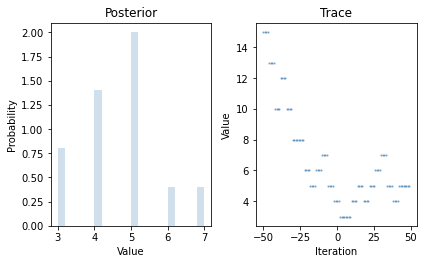

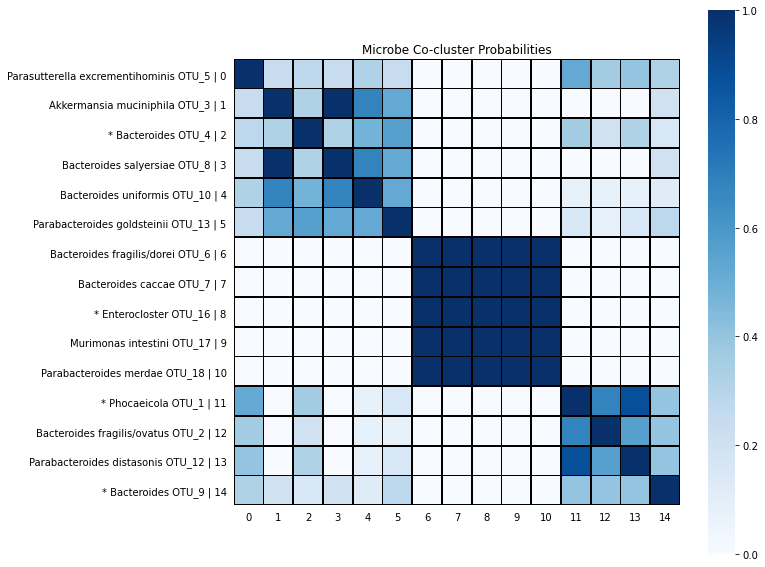

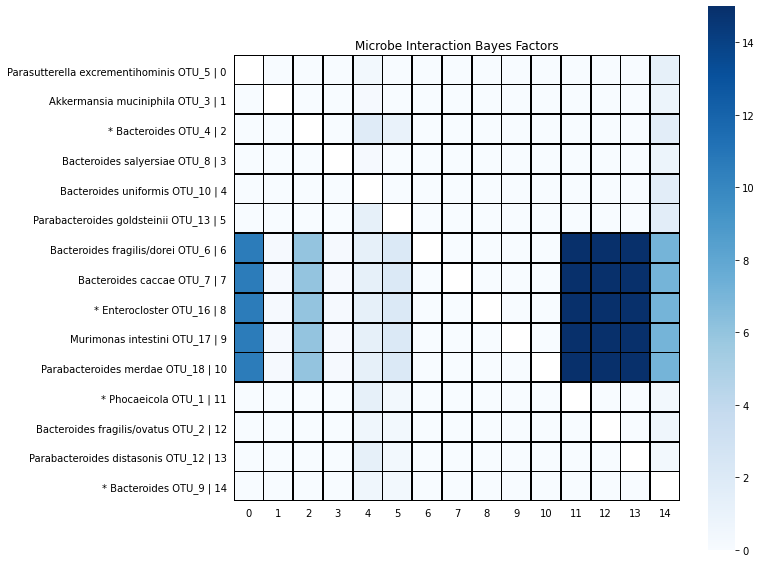

In [20]:
clustering = mcmc_uc1.graph[STRNAMES.CLUSTERING_OBJ]
md2.generate_cluster_assignments_posthoc(clustering, set_as_value=True)
taxas = mcmc_uc1.graph.data.taxas

md2.visualization.render_trace(clustering.n_clusters)
order = []
for i, cluster in enumerate(clustering):
    print('Cluster {}'.format(i))
    for oidx in cluster:
        print('\t', md2.taxaname_for_paper(taxas[oidx], taxas))
        order.append(oidx)

coclusters = md2.summary(mcmc_uc1.graph[STRNAMES.CLUSTERING_OBJ].coclusters)['mean']
md2.visualization.render_cocluster_proportions(
    coclusters, taxas=uc_toy.taxas, yticklabels='%(paperformat)s | %(index)s',
    order=order)

bayes_factors = md2.generate_interation_bayes_factors_posthoc(mcmc_uc1)
md2.visualization.render_bayes_factors(
    bayes_factors, taxas=taxas, yticklabels='%(paperformat)s | %(index)s',
    order=order)

plt.show()

In [22]:
chains = [mcmc_uc0, mcmc_uc1]
start = 10
end = 20
vname = STRNAMES.GROWTH_VALUE

rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Growth values:', rhat)

vname = STRNAMES.CONCENTRATION
rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Concentration parameter:', rhat)

vname = STRNAMES.PROCESSVAR
rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Process variance parameter:', rhat)


Growth values: [0.99130763 0.75740841 0.82327396 0.97709511 0.90449659 1.16105655 1.05717483 0.70767628 0.7237255  0.71412089 1.11568761 0.92429439 0.7665235  1.06447784 0.73192776]
Concentration parameter: 1.12906023223049
Process variance parameter: 0.8433052470128665


# Consensus clustering
Run the model with a fixed modules

In [23]:
# Use the clustering from a previous as the clustering assignment
params = md2.config.MDSINE2ModelConfig(
    basepath=basepath, seed=0, burnin=50, n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, checkpoint=50)

# Do not learn the clustering parameters
params.LEARN[STRNAMES.CLUSTERING] = False
params.LEARN[STRNAMES.CONCENTRATION] = False

# Set the initialization option for clustering
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'fixed-clustering'
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value'] = 'output/mdsine2/uc100/mcmc.pkl'

mcmc = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)
mcmc = md2.run_graph(mcmc, crash_if_error=True)

INFO:base.2534: max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
INFO:run.84: Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
INFO:run.251: There are 372 qPCR measurements for 3 buckets. Each bucket is 124 measurements long
INFO:run.286: Initializing Filtering
INFO:posterior.2649: Setting up the essential timepoints
INFO:posterior.2662: Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  62.  63.  64.  64.5]
INFO:run.286: Initializing Zero inflation
INFO:design_matrices.846: Initializing LHS vector
INFO:design_matrices.1011: Initializing growth design matrix
INFO:design_matrices.939: Initializing self-inte

INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Vancomycin
INFO:run.370: 		value: {2437683352128: 0, 2437722103088: 0, 2437728443248: 0, 2437724144808: 0, 2437695676200: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Gentamicin
INFO:run.370: 		value: {2437683352128: 0, 2437722103088: 0, 2437728443248: 0, 2437724144808: 0, 2437695676200: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.372: Perturbation prior variances:
INFO:run.374: 		dof: 2.5
INFO:run.375: 		scale: 2000.0
INFO:run.376: 		value: 10000.0
INFO:run.374: 		dof: 2.5
INFO:run.375: 		scale: 2000.0
INFO:run.376: 		value: 10000.0
INFO:run.374: 		dof: 2.5
INFO:run.375: 		scale: 2000.0
INFO:run.376: 		value: 10000.0
INFO:run.377: Perturbation indicators:
INFO:run.380: 	perturbation High Fat Diet: [False False False False False]
INFO:run.380: 	perturbation Vancomycin: [False False False False False]
INFO:run.380: 	perturbation Gentamicin: [False False False False False]
INFO:run.381: Perturbation indicator probabilit

INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1033.620077183858
	perturbation Vancomycin: 1108.8231581037192
	perturbation Gentamicin: 1617.0418323061037
INFO:inference.438: Process Variance parameter: 4.615726444077983, empirical_variance: 4.53819
INFO:inference.438: Filtering: parallel
INFO:inference.429: 

Inference iteration 2/100, time: 0.35597681999206543
INFO:inference.438: Cluster interaction indicator parameter: [False  True  True  True False  True False False False False False False False False False  True False False False  True]
total time: 0.02100682258605957, n_interactions: 6/20, 0.30
INFO:inference.438: Cluster interaction probability: 0.31026231569718266
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.010027170181274414s
perturbation High Fat Diet (0/5): [False False False False False]
perturbation Vancomycin (1/5): [F

INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.5413646785810065, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.250657970665614, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 42.81848292751209
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3719.0898137911154
	perturbation Vancomycin: 18728.803562494995
	perturbation Gentamicin: 1805.3539301327173
INFO:inference.438: Process Variance parameter: 4.408619168079476, empirical_variance: 4.48630
INFO:inference.438: Filtering: no-mp - Time: 0.2740, Acc: [0.615, 0.629, 0.612, 0.601, 0.626], data/sec: 20527.76
INFO:inference.429: 

Inference iteration 5/100, time: 0.35900449752807617
INFO:inference.438: Cluster interaction indicator par

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 7.722127266320545
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -64.8981762901076
	perturbation Vancomycin: -76.48336819767063
	perturbation Gentamicin: 165.94603348294586
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.2432089351253894, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.814163402377705, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 163.36683047212225
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1208.468472451047
	perturbation Vancomycin: 1399.4782187418316
	perturbation Genta

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -1.6181501568796628
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 117.39005309128223
	perturbation Vancomycin: -2.26988955530262
	perturbation Gentamicin: -29.667615468179076
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.0359069213463903, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.3889612275963956, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 43.146066410224186
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3724.625793951643
	perturbation Vancomycin: 823.9980176704485
	perturbation Ge

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 0.5943982746519267
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -147.53249867369075
	perturbation Vancomycin: -85.02043650946727
	perturbation Gentamicin: -164.64511156150118
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.0867387174093803, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.4442516359064317, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 121.9736174109906
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1169.5823291308961
	perturbation Vancomycin: 5709.187646858536
	perturbation G

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -18.68060749476679
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -109.85707275553295
	perturbation Vancomycin: 99.48209390485361
	perturbation Gentamicin: 11.709087215544194
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.9308381365854257, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.1490870517239566, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 99.23087935869762
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1990.533423370289
	perturbation Vancomycin: 3786.5231062387043
	perturbation Gen

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 1.2155804405146942
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -114.73390676193694
	perturbation Vancomycin: 6.261277790862792
	perturbation Gentamicin: -92.10795743736193
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.1498144353520821, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.1495187272582554, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 25.736040634096867
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 482.30072053289456
	perturbation Vancomycin: 816.1884028347529
	perturbation Ge

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -3.1491122794967494
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 12.66270453794622
	perturbation Vancomycin: -76.45497038735498
	perturbation Gentamicin: -47.46658689236319
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.36781770849741635, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.1930015487043684, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 40.51618598515178
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3436.2351953520233
	perturbation Vancomycin: 4558.273784927829
	perturbation Ge

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 8.985572194369624
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -108.51621664749167
	perturbation Vancomycin: -41.47600417422016
	perturbation Gentamicin: -66.78578185443266
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.29049840831065976, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.3765814940655625, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 115.89777357489923
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2971.0552843374494
	perturbation Vancomycin: 4522.632988513915
	perturbation G

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 1.4054278346482052
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -94.57864509857141
	perturbation Vancomycin: -46.33680736911997
	perturbation Gentamicin: -24.730545651160966
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.7196862042479429, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.679113706769612, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 154.41153617554548
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1366.838578608944
	perturbation Vancomycin: 6798.428386797454
	perturbation Gen

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -4.16015998807634
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 47.40078672770297
	perturbation Vancomycin: 38.34662442422228
	perturbation Gentamicin: -2.997402605505174
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.439755111187963, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.7367304380236304, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 44.794998027947365
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2102.673921902797
	perturbation Vancomycin: 6352.8510945366515
	perturbation Gentam

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -17.261592219155062
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 12.821455632121845
	perturbation Vancomycin: -3.346753808582844
	perturbation Gentamicin: -155.00346967949784
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.2809962343930885, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.5274845743318117, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 252.84932209021466
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2365.403701243536
	perturbation Vancomycin: 1662.8805001842316
	perturbation 

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 4.7130814915817565
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 99.91498501973653
	perturbation Vancomycin: -53.76772840518452
	perturbation Gentamicin: 55.58344646627322
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.9349095613832745, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.3326736422685888, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 77.08173661039486
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 6334.351816605925
	perturbation Vancomycin: 7427.734401959523
	perturbation Gentam

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 3.8785114366458164
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -87.56818272205503
	perturbation Vancomycin: 32.82502874619624
	perturbation Gentamicin: -24.283466130725678
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.6008789265816865, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.8070391669792434, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 45.8040325260275
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1892.6565998473177
	perturbation Vancomycin: 14786.263863958797
	perturbation Gen

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -5.500025499516102
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 51.802571704260956
	perturbation Vancomycin: 19.32016769707037
	perturbation Gentamicin: -16.73051529001135
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.1281090694997413, Acceptance rate: 0.9767441860465116
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.4052234234001233, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 33.38587857995841
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 869.4834976114576
	perturbation Vancomycin: 6171.607578379312
	per

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -12.808642949526533
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -107.76525525958797
	perturbation Vancomycin: 18.474502068642646
	perturbation Gentamicin: 33.20156588386798
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.3458863758235704, Acceptance rate: 0.9782608695652174
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.080024439677205, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 518.1832328737877
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1822.3763590800806
	perturbation Vancomycin: 890.6423430496067
	p

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -6.33066851352036
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -104.32534480210765
	perturbation Vancomycin: 75.87838704626395
	perturbation Gentamicin: -25.12130298901227
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.9322857963867441, Acceptance rate: 0.9795918367346939
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.1161415892744415, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 89.95155713014731
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4977.22285804421
	perturbation Vancomycin: 4082.338995575569
	pert

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 9.864938620853557
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 1.1419887139007703
	perturbation Vancomycin: -6.548958606989333
	perturbation Gentamicin: 3.5842649375864113
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.079913832469624, Acceptance rate: 0.96
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.4376583563454783, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 99.63775778091076
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 958.3301831687842
	perturbation Vancomycin: 1058.842269995029
	perturbation Genta

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -8.758122455094664
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 67.64086845449899
	perturbation Vancomycin: 43.91593148632615
	perturbation Gentamicin: -6.15254022305642
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.51147450527637, Acceptance rate: 0.94
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.2933751079452889, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 28.572903353417335
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 5287.307197382857
	perturbation Vancomycin: 2426.3926761907396
	perturbation Gentam

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -1.3155194096829024
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -85.90127716936195
	perturbation Vancomycin: 81.01738860020642
	perturbation Gentamicin: 46.31675462993548
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.2015135116428417, Acceptance rate: 0.94
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.269294778803937, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 35.739386722385305
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1259.6688212547922
	perturbation Vancomycin: 14143.109927797379
	perturbation Ge

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -11.34238336402762
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -70.10389258579637
	perturbation Vancomycin: 32.263557120448816
	perturbation Gentamicin: 0.3577340447698385
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.529850167800797, Acceptance rate: 0.94
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.6679559361777554, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 238.97641296311247
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 646.3417496107264
	perturbation Vancomycin: 1035.22233582559
	perturbation Gent

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 4.418904695655491
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 182.23925112952023
	perturbation Vancomycin: -24.930686163406243
	perturbation Gentamicin: 83.77569391949423
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.1093089165451944, Acceptance rate: 0.94
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.9314315303988419, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 20.222573545922234
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 17456.15627404348
	perturbation Vancomycin: 777.908726245631
	perturbation Gent

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -4.812476354639155
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -94.14961840848045
	perturbation Vancomycin: 75.45916915722532
	perturbation Gentamicin: 23.35917859341719
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.1976367627472295, Acceptance rate: 0.94
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.2143867694429114, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 22.0014538705608
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 13112.0459424605
	perturbation Vancomycin: 4671.711288411438
	perturbation Gentam

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 0.9872531711938087
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -103.58433002840923
	perturbation Vancomycin: 4.272680171401218
	perturbation Gentamicin: 1.6437570292376869
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.033934982725838, Acceptance rate: 0.94
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.834661212611184, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 101.20994221152705
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 84469.0798978697
	perturbation Vancomycin: 694.972963522328
	perturbation Genta

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 4.909948455725275
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -67.23387824744326
	perturbation Vancomycin: -1.676830253303611
	perturbation Gentamicin: -4.621639776172731
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.859449815437104, Acceptance rate: 0.94
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.7191213051800437, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 25.323363673252047
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2172.2155167969445
	perturbation Vancomycin: 1027.2552253443257
	perturbation G

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -5.2199754828175315
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 98.26358852426547
	perturbation Vancomycin: 89.65670828903332
	perturbation Gentamicin: 13.86247718858699
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.3102175789731687, Acceptance rate: 0.92
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.584464669833324, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 45.14075179591467
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1494.996855712609
	perturbation Vancomycin: 1795.6298924974042
	perturbation Gent

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -19.71422520941715
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -130.6643309638486
	perturbation Vancomycin: 56.03686225806242
	perturbation Gentamicin: 6.076817119426206
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.243310611785424, Acceptance rate: 0.92
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.9614915077333159, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 126.64010259586223
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4718.563039634299
	perturbation Vancomycin: 1982.2348247095051
	perturbation Gen

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 12.250980649072352
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -53.81562665283155
	perturbation Vancomycin: 29.5680617424065
	perturbation Gentamicin: -2.144154427042174
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.8175024039829406, Acceptance rate: 0.92
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.3386879571313308, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 65.76158294692533
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 5749.828548486815
	perturbation Vancomycin: 978.8793815712962
	perturbation Gent

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 4.86609110488964
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 28.9383164340225
	perturbation Vancomycin: -76.93198235331934
	perturbation Gentamicin: 35.809225999752954
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.2560189110133622, Acceptance rate: 0.92
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.3585544116052444, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 673.2158644399159
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 102167.08078263226
	perturbation Vancomycin: 10498.539808184847
	perturbation Gent

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -0.8394967283790028
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -52.6424256543021
	perturbation Vancomycin: 40.56326678871055
	perturbation Gentamicin: -42.32471884083522
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.0503704186084035, Acceptance rate: 0.92
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.177578978809292, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 61.466384722196096
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2233.3309823251616
	perturbation Vancomycin: 724.7847523441903
	perturbation Ge

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 11.056343135339906
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 20.23030772723298
	perturbation Vancomycin: 6.047948971979311
	perturbation Gentamicin: 7.021129798984398
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.1972245008084166, Acceptance rate: 0.94
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.7657291332129128, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 109.69466166630404
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3882.2618783648836
	perturbation Vancomycin: 604.452924103529
	perturbation Gent

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -13.707518455230788
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 194.57161596294713
	perturbation Vancomycin: 29.86488699954494
	perturbation Gentamicin: -4.465987840130923
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.6362338244477688, Acceptance rate: 0.94
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.503558619440513, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 433.81317435177556
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1712.5620122642956
	perturbation Vancomycin: 2336.4839160121032
	perturbation 

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 12.962374298342322
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 36.129464137114766
	perturbation Vancomycin: -16.880949910564244
	perturbation Gentamicin: -6.431778528011172
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.5055098089262522, Acceptance rate: 0.94
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.3978067196942336, Acceptance rate: 0.98
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 80.63519282452336
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 657.4930737766786
	perturbation Vancomycin: 1137.789058517185
	perturbation G

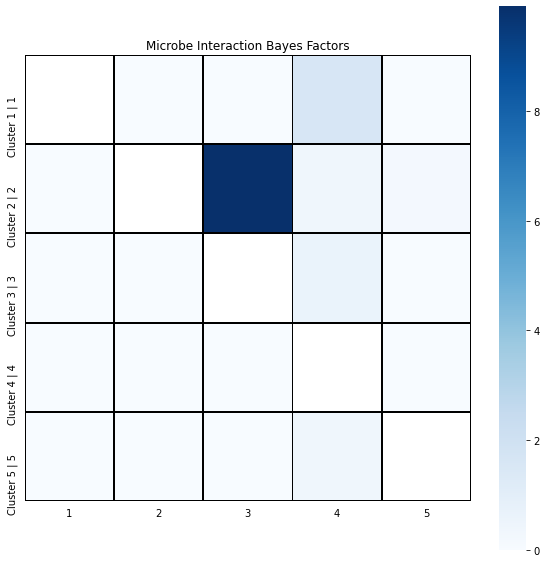

In [24]:
# Plot the posterior
taxas = mcmc.graph.data.taxas

clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
bf_taxa = md2.generate_interation_bayes_factors_posthoc(mcmc)
bf_clustering = md2.condense_fixed_clustering_interaction_matrix(bf_taxa, clustering=clustering)

labels = ['Cluster {} | {}'.format(i+1, i+1) for i in range(len(clustering))]
md2.visualization.render_bayes_factors(bf_clustering, yticklabels=labels)
plt.show()

# Cross validation

Take out a single subject and use that as initial conditions for forward simulation

In [25]:
# Make the data and validation Study objects
study = md2.dataset.parse(
    name='uc-toy-dataset', 
    taxonomy='data/uc-toy/taxonomy.tsv', 
    reads='data/uc-toy/reads.tsv', 
    qpcr='data/uc-toy/qpcr.tsv', 
    perturbations='data/uc-toy/perturbations.tsv', 
    metadata='data/uc-toy/metadata.tsv')

val = study.pop_subject('8')
val.name += '-validate'

print(study.name)
for subj in study:
    print(subj.name)
for pert in study.perturbations:
    print(pert)
print()
print(val.name)
for subj in val:
    print(subj.name)
for pert in val.perturbations:
    print(pert)


INFO:base.1117: TaxaSet parsng new taxonomy table. Resetting


uc-toy-dataset
10
6
7
9
Perturbation High Fat Diet:
	Subject 6: (21.5, 28.5)
	Subject 7: (21.5, 28.5)
	Subject 9: (21.5, 28.5)
	Subject 10: (21.5, 28.5)

Perturbation Vancomycin:
	Subject 6: (35.5, 42.5)
	Subject 7: (35.5, 42.5)
	Subject 9: (35.5, 42.5)
	Subject 10: (35.5, 42.5)

Perturbation Gentamicin:
	Subject 6: (50.5, 57.5)
	Subject 7: (50.5, 57.5)
	Subject 9: (50.5, 57.5)
	Subject 10: (50.5, 57.5)


unnamed-study-validate
8
Perturbation High Fat Diet:
	Subject 8: (21.5, 28.5)

Perturbation Vancomycin:
	Subject 8: (35.5, 42.5)

Perturbation Gentamicin:
	Subject 8: (50.5, 57.5)



In [26]:
# Learn the model
params = md2.config.MDSINE2ModelConfig(
    basepath='output/mdsine2/cv/'+study.name, seed=0, 
    burnin=50, n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, checkpoint=50)
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'
mcmc = md2.initialize_graph(params=params, graph_name=study.name, subjset=study)
mcmc = md2.run_graph(mcmc, crash_if_error=True)

INFO:base.2534: max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
INFO:run.84: Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
INFO:run.251: There are 297 qPCR measurements for 3 buckets. Each bucket is 99 measurements long
INFO:run.286: Initializing Filtering
INFO:posterior.2649: Setting up the essential timepoints
INFO:posterior.2662: Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  62.  63.  64.  64.5]
INFO:run.286: Initializing Zero inflation
INFO:design_matrices.846: Initializing LHS vector
INFO:design_matrices.1011: Initializing growth design matrix
INFO:design_matrices.939: Initializing self-inter

INFO:run.369: 	perturbation High Fat Diet
INFO:run.370: 		value: {2437734655872: 0, 2437728705112: 0, 2437728705168: 0, 2437728969336: 0, 2437677945968: 0, 2437729495920: 0, 2437729496088: 0, 2437729496144: 0, 2437684142320: 0, 2437684142432: 0, 2437684142544: 0, 2437684142880: 0, 2437684143104: 0, 2437684143216: 0, 2437684143552: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Vancomycin
INFO:run.370: 		value: {2437734655872: 0, 2437728705112: 0, 2437728705168: 0, 2437728969336: 0, 2437677945968: 0, 2437729495920: 0, 2437729496088: 0, 2437729496144: 0, 2437684142320: 0, 2437684142432: 0, 2437684142544: 0, 2437684142880: 0, 2437684143104: 0, 2437684143216: 0, 2437684143552: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Gentamicin
INFO:run.370: 		value: {2437734655872: 0, 2437728705112: 0, 2437728705168: 0, 2437728969336: 0, 2437677945968: 0, 2437729495920: 0, 2437729496088: 0, 2437729496144: 0, 2437684142320: 0, 2437684142432: 0, 2437684142544: 0, 243768414288

INFO:inference.438: Cluster interaction probability: 0.5907630856509913
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.028000593185424805s
perturbation High Fat Diet (9/15): [False  True False  True  True False  True  True  True  True False  True  True False False]
perturbation Vancomycin (10/15): [False  True False  True  True  True  True False  True False  True False  True  True  True]
perturbation Gentamicin (11/15): [False  True  True False  True  True False  True False  True  True  True  True  True  True]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.5032813527614807
	perturbation Vancomycin: 0.606532764595715
	perturbation Gentamicin: 0.65283684507178
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.16729313 0.38474118 0.65715856 0.37039815 0.60867957 0

INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.10972506 0.21148443 0.43925925 0.34365468 0.67488577 0.70132305 0.28162154 0.30065323 0.29477391 0.29784929 0.33265642 0.45148658 1.44128478 0.78970728 0.06458668]
Self Interactions:
[1.32745348e-01 1.23881716e-01 1.78659679e-01 5.65656439e-01 1.17473680e+00 1.03254784e+00 4.13167191e-02 6.53079735e-01 3.72199788e+01 8.73839888e+01 3.22004535e-01 8.53225905e+01 3.68086562e+00 1.39783576e+00 1.65678417e+00]
Interactions:
[-77.49646579  67.48763089   5.15166016   0.57347955   3.37905664 -44.02942331   0.11516085  49.23850219  -6.09884891 -30.41495227 -54.69767729  -1.68261957  10.86261459   0.29298456  -2.09105291  28.21435316  -1.30003362  23.36454725  -3.20815841 -16.97049929 -45.63522185   3.62333115 -43.06296863 -18.94839314  -3.82427379 -21.95339478  14.28409504  67.11968828  -2.19732424   9.90394752   8.9801119    2.29255911  55.01367056 -30.35258535  -1.59735015 -55.3

INFO:inference.438: Clustering concentration parameter: 1028.3260132447924
INFO:inference.429: 

Inference iteration 4/100, time: 0.3709733486175537
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fal

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -59.56548232362257
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 112.77836301278023
	perturbation Vancomycin: 43.758547237931694
	perturbation Gentamicin: 103.29891945199456
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.8426204778425026, Acceptance rate: 1.0
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.07471409926827421, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 347.43075185696097
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 821.7305222884659
	perturbation Vancomycin: 1836.3085429804175
	perturbation G

INFO:inference.438: Cluster interaction probability: 0.0018577960620059617
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.012001276016235352s
perturbation High Fat Diet (2/15): [False False False False False  True False False  True False False False False False False]
perturbation Vancomycin (3/15): [False False False False False False  True  True False False False False False False  True]
perturbation Gentamicin (0/15): [False False False False False False False False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.1086956386411362
	perturbation Vancomycin: 0.0897347436348209
	perturbation Gentamicin: 0.03532776678325556
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.50037082 0.52311915 0.20572461 0.15906428 0.37729

INFO:inference.438: Clustering concentration parameter: 140.9078225950882
INFO:posterior.1569: 0/15: 2
INFO:posterior.1569: 1/15: 7
INFO:posterior.1569: 2/15: 3
INFO:posterior.1569: 3/15: 6
INFO:posterior.1569: 4/15: 1
INFO:posterior.1569: 5/15: 13
INFO:posterior.1569: 6/15: 8
INFO:posterior.1569: 7/15: 0
INFO:posterior.1569: 8/15: 5
INFO:posterior.1569: 9/15: 4
INFO:posterior.1569: 10/15: 14
INFO:posterior.1569: 11/15: 9
INFO:posterior.1569: 12/15: 10
INFO:posterior.1569: 13/15: 11
INFO:posterior.1569: 14/15: 12
INFO:inference.429: 

Inference iteration 9/100, time: 0.8569927215576172
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fal

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -66.69836082858919
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -18.680954083890892
	perturbation Vancomycin: -36.24568792925337
	perturbation Gentamicin: 50.46942130462113
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.44010924033125, Acceptance rate: 0.9
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.5799708116413829, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 15287.743242553692
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2261.321099367641
	perturbation Vancomycin: 2229.1558002775573
	perturbation Gent

INFO:inference.438: Cluster interaction probability: 5.139356877196297e-06
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.009999275207519531s
perturbation High Fat Diet (0/14): [False False False False False False False False False False False False False False]
perturbation Vancomycin (2/14): [ True False False False False False False False False False False False False  True]
perturbation Gentamicin (0/14): [False False False False False False False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.004181017733358052
	perturbation Vancomycin: 0.05229926968925037
	perturbation Gentamicin: 0.024957161353312243
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.36494258 0.18792159 0.45779191 0.13787616 0.48454079 0.05839657

INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 14
Cluster 2437734691336
	members: ['OTU_16', 'OTU_17']
	size: 2
Cluster 2437728969336
	members: ['OTU_7']
	size: 1
Cluster 2437697499600
	members: ['OTU_12']
	size: 1
Cluster 2437697204520
	members: ['OTU_8']
	size: 1
Cluster 2437684047152
	members: ['OTU_18']
	size: 1
Cluster 2437683425688
	members: ['OTU_10']
	size: 1
Cluster 2437702690072
	members: ['OTU_9']
	size: 1
Cluster 2437729495920
	members: ['OTU_3']
	size: 1
Cluster 2437721903176
	members: ['OTU_4']
	size: 1
Cluster 2437697561096
	members: ['OTU_13']
	size: 1
Cluster 2437684142544
	members: ['OTU_6']
	size: 1
Cluster 2437696627656
	members: ['OTU_5']
	size: 1
Cluster 2437671200472
	members: ['OTU_2']
	size: 1
Cluster 2437671199128
	members: ['OTU_1']
	size: 1
no mp - Total time: 0.5660099983215332
INFO:inference.438: Clustering concentration parameter: 221.04826133462552
INFO:inference.429: 

Infere

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -89.67890815449562
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -206.8937637290207
	perturbation Vancomycin: 14.764775951921571
	perturbation Gentamicin: -118.75539872717329
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.2460380167330176, Acceptance rate: 0.9333333333333333
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.3896674808254445, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 23.320637164415075
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1158.5997931837164
	perturbation Vancomycin: 1562.4735628820972

INFO:inference.438: Cluster interaction probability: 0.004598881086415299
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.010988950729370117s
perturbation High Fat Diet (0/13): [False False False False False False False False False False False False False]
perturbation Vancomycin (1/13): [ True False False False False False False False False False False False False]
perturbation Gentamicin (5/13): [False  True False False False False  True  True False False  True False  True]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0001679027614001275
	perturbation Vancomycin: 0.040940989041821405
	perturbation Gentamicin: 0.20483779375635303
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.38031175 0.35571831 0.38179046 0.20911108 0.55986299 0.06095593 0.43348154 0.2411

INFO:inference.438: Clustering concentration parameter: 46.61425751118004
INFO:inference.429: 

Inference iteration 19/100, time: 0.3080310821533203
INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fal

INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 11076.589562264937
	perturbation Vancomycin: 7074.740200322559
	perturbation Gentamicin: 4557.510936103714
INFO:inference.438: Process Variance parameter: 4.107334236719334, empirical_variance: 4.04363
INFO:inference.438: Filtering: no-mp - Time: 0.2450, Acc: [0.642, 0.605, 0.628, 0.588], data/sec: 18367.43
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 13
Cluster 2437734691336
	members: ['OTU_16', 'OTU_17']
	size: 2
Cluster 2437697396976
	members: ['OTU_6']
	size: 1
Cluster 2437729390832
	members: ['OTU_4']
	size: 1
Cluster 2437675585488
	members: ['OTU_1', 'OTU_8']
	size: 2
Cluster 2437671200472
	members: ['OTU_2']
	size: 1
Cluster 2437692666376
	members: ['OTU_3']
	size: 1
Cluster 2437690357240
	members: ['OTU_18']
	size: 1
Cluster 2437684047152
	me

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -66.97632569638463
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 66.11012109529439
	perturbation Vancomycin: 15.235211075565722
	perturbation Gentamicin: 167.30988363184878
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.7123593829908097, Acceptance rate: 0.9545454545454546
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.6435142506703988, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 47.72026229921797
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4260.730772677141
	perturbation Vancomycin: 790.7694930792247
	per

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -123.22648004401704
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 96.10954060879003
	perturbation Vancomycin: 6.862651455973586
	perturbation Gentamicin: 242.62448345186522
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.3948609996659416, Acceptance rate: 0.9583333333333334
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.5951847781774333, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 256.5121681207135
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4126.122488597565
	perturbation Vancomycin: 500.40137722458604
	pe

INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.010005639784466292
	perturbation Vancomycin: 0.054385507044463634
	perturbation Gentamicin: 0.07012753457796653
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.61259336 0.50326743 0.56214317 0.01417741 0.56235591 0.3172097  0.30364375 0.26602175 0.31102685 0.00873885 0.38992039 0.24154148 0.81048647 0.703617   0.20656845]
Self Interactions:
[  0.43483079   0.33537971   0.21540105   6.73060064   0.98309647   0.49263835   2.24174549   0.92065658  86.92545674 120.74748996   2.25193103  93.23087843   4.48464382   4.80181939   3.46951254]
Interactions:
[]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-2.24842006]
	 perturbation Gentamicin: []
INFO:inference.438: Mean parameter for the nor

INFO:inference.438: Cluster interaction probability: 0.0006016665020676054
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.010998964309692383s
perturbation High Fat Diet (1/11): [False False False False  True False False False False False False]
perturbation Vancomycin (1/11): [ True False False False False False False False False False False]
perturbation Gentamicin (0/11): [False False False False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.07974703434716572
	perturbation Vancomycin: 0.07164206475255551
	perturbation Gentamicin: 0.035804336995344604
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.50320673 0.55421466 0.6064414  0.13247656 0.64839987 0.24282794 0.55983564 0.37455087 0.28071228 0.03212107 0.28525897

INFO:inference.438: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False]
total time: 0.01902484893798828, n_interactions: 0/56, 0.00
INFO:inference.438: Cluster interaction probability: 0.024096357845205422
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.006999969482421875s
perturbation High Fat Diet (0/8): [False False False False False False False False]
perturbation Vancomycin (2/8): [False False False  True  True False False False]
perturbation Gentamicin (0/8): [False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbatio

INFO:inference.438: Cluster interaction probability: 0.001771687303299561
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.008966445922851562s
perturbation High Fat Diet (0/8): [False False False False False False False False]
perturbation Vancomycin (1/8): [False False False False  True False False False]
perturbation Gentamicin (0/8): [False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.002231969434909872
	perturbation Vancomycin: 0.033746356752098056
	perturbation Gentamicin: 0.0004064827435233998
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.60338502 0.49179805 0.44917224 0.15504233 0.3967781  0.17945962 0.36114619 0.62612564 0.20541795 0.01166743 0.44434011 0.18395781 1.00837851 0.63681115 0.25851753]
Self Inte

INFO:inference.438: Cluster interaction probability: 0.0012223115077585605
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.00800013542175293s
perturbation High Fat Diet (0/8): [False False False False False False False False]
perturbation Vancomycin (1/8): [False  True False False False False False False]
perturbation Gentamicin (0/8): [False False False False False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0005527884798792539
	perturbation Vancomycin: 0.013284273937300535
	perturbation Gentamicin: 0.15568076878705778
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.49177954 0.64207644 0.46942492 0.18961536 0.5309776  0.48459489 0.48659755 0.55999015 0.19855568 0.14001357 0.72539856 0.41395921 1.05400969 0.736162   0.49324451]
Self Inter

INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.03291776700646202
	perturbation Vancomycin: 0.21683190886739503
	perturbation Gentamicin: 0.012977994627817752
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.67593933 0.15564762 0.3919034  0.36546579 0.67188963 0.55762839 0.13682314 0.15571378 0.47312882 0.06217551 0.36989625 0.2688977  1.10092898 1.05539746 0.62219601]
Self Interactions:
[  0.40817606   0.18838595   0.17979772   7.87263064   0.94840093   0.69863099   1.81260254   0.92034206 109.82893964 134.75989605   2.25032633 123.78322921   5.1261905    3.25832887   5.23753999]
Interactions:
[-1.27509244]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.15756913]
	 perturbation Gentamicin: []
INFO:inference.438: Mean parameter f

INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.23098111869407836
	perturbation Vancomycin: 0.37824829840941193
	perturbation Gentamicin: 0.05038606397477698
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.39187161 0.63561933 0.5111095  0.22106661 0.33905116 0.57665007 0.59086067 0.45013886 0.38904286 0.02562646 0.63788201 0.20118572 0.61928396 0.86863418 0.59812248]
Self Interactions:
[4.34970157e-01 1.66498538e-01 1.78594512e-01 3.01468823e+00 6.18568635e-01 5.61013147e-01 2.41887605e+00 1.05350540e+00 1.14961595e+02 2.15803731e+02 2.52430613e+00 1.21396310e+02 2.69254095e+00 3.87273062e+00 3.88775490e+00]
Interactions:
[-0.1096348   4.39762057 -1.31990265]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: [51.12074459]
	 perturbation Vancomycin: [-2.0213348]
	 p

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 6.4739346907275594
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -112.42006139971859
	perturbation Vancomycin: 9.117733400162411
	perturbation Gentamicin: -31.301318298102387
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.3362890885060665, Acceptance rate: 0.95
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.311823331883549, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 96.30536212363056
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 5553.718118187145
	perturbation Vancomycin: 5503.060587079735
	perturbation Gen

INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.3029337959605416, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 27.626426471769687
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 852.4993452698034
	perturbation Vancomycin: 26072.53050540807
	perturbation Gentamicin: 2803.7616127505557
INFO:inference.438: Process Variance parameter: 3.5031130870066955, empirical_variance: 3.43586
INFO:inference.438: Filtering: no-mp - Time: 0.2330, Acc: [0.630, 0.620, 0.614, 0.618], data/sec: 19310.30
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 2437693590888
	members: ['OTU_4', 'OTU_8', 'OTU_6', 'OTU_9', 'OTU_17', 'OTU_16', 'OTU_3']
	size: 7
Cluster 2437688202856
	members: ['OTU_

INFO:inference.438: Clustering concentration parameter: 1.298763656331777
INFO:posterior.1569: 0/15: 12
INFO:posterior.1569: 1/15: 5
INFO:posterior.1569: 2/15: 8
INFO:posterior.1569: 3/15: 10
INFO:posterior.1569: 4/15: 9
INFO:posterior.1569: 5/15: 1
INFO:posterior.1569: 6/15: 7
INFO:posterior.1569: 7/15: 6
INFO:posterior.1569: 8/15: 0
INFO:posterior.1569: 9/15: 3
INFO:posterior.1569: 10/15: 4
INFO:posterior.1569: 11/15: 13
INFO:posterior.1569: 12/15: 2
INFO:posterior.1569: 13/15: 11
INFO:posterior.1569: 14/15: 14
INFO:inference.429: 

Inference iteration 45/100, time: 0.47497105598449707
INFO:inference.438: Cluster interaction indicator parameter: [ True False False False False False False False False False False False False False False False False False False False]
total time: 0.011025667190551758, n_interactions: 1/20, 0.05
INFO:inference.438: Cluster interaction probability: 0.11286053713393834
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.

INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.39971393 0.4076535  0.84715702 0.4760971  0.64347444 0.68690692 0.60948328 0.49277843 0.35142253 0.14362932 0.42450863 0.21289609 1.03041088 0.91374701 0.49524197]
Self Interactions:
[3.65066493e-01 2.51819692e-01 1.73133491e-01 5.47423062e+00 1.17243385e+00 3.98697198e-01 1.08311994e+00 4.89459236e-01 1.48817912e+02 2.14815300e+02 2.05058815e+00 1.38935329e+02 2.57466733e+00 3.12046234e+00 4.32962787e+00]
Interactions:
[-0.4476937]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.28270008]
	 perturbation Gentamicin: []
INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -4.7794494065469575
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 18.009638587926354
	perturbatio

INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.6108239228237187, Acceptance rate: 0.9591836734693877
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.4513906236281669, Acceptance rate: 1.0
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 140.04614390587702
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1181.2329398029224
	perturbation Vancomycin: 2263.5796819550537
	perturbation Gentamicin: 2255.9940349570884
INFO:inference.438: Process Variance parameter: 3.013268030048419, empirical_variance: 3.13453
INFO:inference.438: Filtering: no-mp - Time: 0.2150, Acc: [0.626, 0.620, 0.622, 0.606], data/sec: 20929.94
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_cl

INFO:inference.438: Cluster interaction probability: 0.10859849533310133
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.006977558135986328s
perturbation High Fat Diet (0/3): [False False False]
perturbation Vancomycin (0/3): [False False False]
perturbation Gentamicin (0/3): [False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0021482174064728255
	perturbation Vancomycin: 0.0031588380970314187
	perturbation Gentamicin: 0.06089889600765905
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.73626524 0.88030027 0.72855217 0.61112236 0.5281084  0.47181937 0.64883881 0.5510454  0.13323994 0.12622066 0.50805749 0.24044431 0.82787547 0.68116916 0.74375624]
Self Interactions:
[5.12128848e-01 4.10749182e-01 1.53878891e-01 1.31388129e+01 1.38958235e+00 4.263

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -21.15093056156529
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -7.3392545471335335
	perturbation Vancomycin: 1.098920356975793
	perturbation Gentamicin: 164.69009154548934
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.7463852295778024, Acceptance rate: 0.96
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.06237376478270645, Acceptance rate: 0.96
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 202.85253189573726
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1514.4742411312616
	perturbation Vancomycin: 2261.116169160762
	perturbation

INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 2437693590888
	members: ['OTU_4', 'OTU_6', 'OTU_3', 'OTU_7', 'OTU_16', 'OTU_8', 'OTU_18', 'OTU_17']
	size: 8
Cluster 2437688202856
	members: ['OTU_2', 'OTU_12', 'OTU_13']
	size: 3
Cluster 2437701197776
	members: ['OTU_1']
	size: 1
Cluster 2437697179720
	members: ['OTU_9']
	size: 1
Cluster 2437698229808
	members: ['OTU_5', 'OTU_10']
	size: 2
no mp - Total time: 0.21699976921081543
INFO:inference.438: Clustering concentration parameter: 2.4189208617668254
INFO:posterior.1569: 0/15: 13
INFO:posterior.1569: 1/15: 12
INFO:posterior.1569: 2/15: 1
INFO:posterior.1569: 3/15: 6
INFO:posterior.1569: 4/15: 14
INFO:posterior.1569: 5/15: 7
INFO:posterior.1569: 6/15: 2
INFO:posterior.1569: 7/15: 3
INFO:posterior.1569: 8/15: 9
INFO:posterior.1569: 9/15: 11
INFO:posterior.1569: 10/15: 0
INFO:posterior.1569: 11/15: 8
INFO:posterior.1569: 12/15: 4
INFO:posterior.1569: 1

INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.006999015808105469s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (0/4): [False False False False]
perturbation Gentamicin (0/4): [False False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.012461339311470048
	perturbation Vancomycin: 0.04730938341119962
	perturbation Gentamicin: 0.037397996877932146
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.59699063 0.64162908 0.77645792 0.49614217 0.50193968 0.74325716 0.30642966 0.44342073 0.28532158 0.17237799 0.70575387 0.2247894  0.6900198  0.61856763 0.69639482]
Self Interactions:
[4.09785259e-01 2.30387514e-01 1.46248761e-01 5.63543727e+00 1.11060021e+00 2.59353175e-01 4.80484381e-01 3.39287085e-01 1.94641921e+02 2.

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: 1.850123268687029
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 129.10563306593878
	perturbation Vancomycin: 127.06398926183189
	perturbation Gentamicin: -35.39744651149948
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.3016874121836766, Acceptance rate: 0.98
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.526767177691717, Acceptance rate: 0.96
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 123.04593712010731
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 11044.197862377454
	perturbation Vancomycin: 1588.5704740534197
	perturbation G

INFO:inference.438: Process Variance parameter: 2.819552670424135, empirical_variance: 2.80312
INFO:inference.438: Filtering: no-mp - Time: 0.2250, Acc: [0.652, 0.619, 0.636, 0.605], data/sec: 19997.64
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 6
Cluster 2437693590888
	members: ['OTU_6', 'OTU_7', 'OTU_8', 'OTU_3', 'OTU_16', 'OTU_17', 'OTU_4', 'OTU_18']
	size: 8
Cluster 2437688202856
	members: ['OTU_2', 'OTU_12', 'OTU_13']
	size: 3
Cluster 2437728536336
	members: ['OTU_1']
	size: 1
Cluster 2437683463896
	members: ['OTU_9']
	size: 1
Cluster 2437694721104
	members: ['OTU_10']
	size: 1
Cluster 2437692666376
	members: ['OTU_5']
	size: 1
no mp - Total time: 0.2179722785949707
INFO:inference.438: Clustering concentration parameter: 2.381452816858728
INFO:inference.429: 

Inference iteration 64/100, time: 0.2779982089996338
INFO:inference.438: Cluster interaction indicator parameter: [ True False False False Fal

INFO:inference.438: Clustering concentration parameter: 2.178638062084869
INFO:inference.429: 

Inference iteration 66/100, time: 0.2859978675842285
INFO:inference.438: Cluster interaction indicator parameter: [ True False False  True False False]
total time: 0.007027864456176758, n_interactions: 2/6, 0.33
INFO:inference.438: Cluster interaction probability: 0.12505409526533276
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.00597381591796875s
perturbation High Fat Diet (0/3): [False False False]
perturbation Vancomycin (1/3): [ True False False]
perturbation Gentamicin (0/3): [False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.013736822071289992
	perturbation Vancomycin: 0.21760202998745817
	perturbation Gentamicin: 0.04894824108277076
INFO:inference.438: Logistic growth parameters (growth, self-interactions, 

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -8.035453414631839
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 75.03797931131109
	perturbation Vancomycin: -13.246074198949199
	perturbation Gentamicin: 140.20084475721484
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.5924252279736764, Acceptance rate: 0.98
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.4575666433067542, Acceptance rate: 0.96
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 36.637229324193754
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1240.2498044823687
	perturbation Vancomycin: 622.0006572921397
	perturbation 

INFO:inference.438: Filtering: no-mp - Time: 0.2410, Acc: [0.627, 0.612, 0.644, 0.632], data/sec: 18671.82
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Cluster 2437693590888
	members: ['OTU_6', 'OTU_8', 'OTU_7', 'OTU_16', 'OTU_17', 'OTU_3', 'OTU_18']
	size: 7
Cluster 2437688202856
	members: ['OTU_1', 'OTU_2', 'OTU_4', 'OTU_5', 'OTU_10', 'OTU_12']
	size: 6
Cluster 2437698229808
	members: ['OTU_9', 'OTU_13']
	size: 2
no mp - Total time: 0.17599892616271973
INFO:inference.438: Clustering concentration parameter: 0.5121414913407516
INFO:inference.429: 

Inference iteration 71/100, time: 0.2739992141723633
INFO:inference.438: Cluster interaction indicator parameter: [ True False False  True False False]
total time: 0.005989551544189453, n_interactions: 2/6, 0.33
INFO:inference.438: Cluster interaction probability: 0.10751113581621242
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicator

INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.07929857192793438
	perturbation Vancomycin: 0.381561395066047
	perturbation Gentamicin: 0.0031008664154846223
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.56576545 0.50123499 0.78582908 0.08484294 0.54701493 0.45414066 0.41774995 0.67473963 0.30236226 0.02888501 0.52523028 0.30195146 1.00928607 0.95922323 0.60484346]
Self Interactions:
[2.63927199e-01 1.74908558e-01 1.11855188e-01 5.08851712e+00 1.34354343e+00 2.56151571e-01 3.42128668e-02 1.64252061e-02 2.79178109e+02 1.84150482e+02 2.53155131e+00 1.29190566e+02 2.38476314e+00 2.65432878e+00 8.98421820e-01]
Interactions:
[ -0.11291554 -19.8022287 ]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.00837631]
	 perturbation Gentamic

INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 69.62356046375423
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 8666.087032592593
	perturbation Vancomycin: 6995.4378120719175
	perturbation Gentamicin: 6831.651908484112
INFO:inference.438: Process Variance parameter: 2.7265632241084483, empirical_variance: 2.64172
INFO:inference.438: Filtering: no-mp - Time: 0.2640, Acc: [0.615, 0.609, 0.621, 0.615], data/sec: 17045.50
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Cluster 2437693590888
	members: ['OTU_6', 'OTU_8', 'OTU_7', 'OTU_16', 'OTU_17', 'OTU_3', 'OTU_18']
	size: 7
Cluster 2437688202856
	members: ['OTU_4', 'OTU_5', 'OTU_1', 'OTU_10', 'OTU_12', 'OTU_2']
	size: 6
Cluster 2437698229808
	members: ['OTU_9', 'OTU_13']
	size: 2
no mp - Total time: 0.159000

INFO:inference.438: Clustering concentration parameter: 0.4087522963630376
INFO:inference.429: 

Inference iteration 78/100, time: 0.2880077362060547
INFO:inference.438: Cluster interaction indicator parameter: [ True False False False  True False False False False False False False]
total time: 0.009018898010253906, n_interactions: 2/12, 0.17
INFO:inference.438: Cluster interaction probability: 0.07492992411723137
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.00697636604309082s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (1/4): [ True False False False]
perturbation Gentamicin (1/4): [ True False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.5094690282036017
	perturbation Vancomycin: 0.041489655790143846
	perturbation Gentamicin: 0.2873078908397158
INFO:inference.438: L

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -11.679778877614277
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -98.03956260041787
	perturbation Vancomycin: 5.410829435572057
	perturbation Gentamicin: -38.425749285875206
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.1485650407979402, Acceptance rate: 0.98
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.099668232929129, Acceptance rate: 0.96
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 232.41339381872052
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1128.5416243202899
	perturbation Vancomycin: 1453.7629661679716
	perturbation

INFO:inference.438: Process Variance parameter: 2.489664724912161, empirical_variance: 2.43918
INFO:inference.438: Filtering: no-mp - Time: 0.2580, Acc: [0.648, 0.612, 0.626, 0.601], data/sec: 17442.00
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Cluster 2437693590888
	members: ['OTU_6', 'OTU_8', 'OTU_7', 'OTU_16', 'OTU_17', 'OTU_3', 'OTU_18']
	size: 7
Cluster 2437688202856
	members: ['OTU_5', 'OTU_4', 'OTU_2', 'OTU_10', 'OTU_1', 'OTU_9', 'OTU_12']
	size: 7
Cluster 2437698228632
	members: ['OTU_13']
	size: 1
no mp - Total time: 0.17899656295776367
INFO:inference.438: Clustering concentration parameter: 0.7059558083126884
INFO:inference.429: 

Inference iteration 83/100, time: 0.275998592376709
INFO:inference.438: Cluster interaction indicator parameter: [ True False False  True False False]
total time: 0.007976293563842773, n_interactions: 2/6, 0.33
INFO:inference.438: Cluster interaction probability: 0.

INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.12806112088327673
	perturbation Vancomycin: 0.3542540136990049
	perturbation Gentamicin: 0.3495222815897753
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.79253131 0.57710555 0.73226066 0.19092695 0.3871307  0.64213646 0.41881905 0.61424482 0.31211472 0.14451669 0.48388752 0.26239391 0.78950672 1.02047481 0.57156501]
Self Interactions:
[5.16088080e-01 1.78726872e-01 9.21462469e-02 6.02219113e+00 8.98865479e-01 1.26618346e-01 6.24857705e-02 6.37140873e-02 1.87519122e+02 1.74190303e+02 2.06349648e+00 1.47332006e+02 1.83022114e+00 2.91048770e+00 1.22922962e+00]
Interactions:
[ -0.12149477 -22.79468894]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-0.47208237]
	 perturbation Gentamicin

INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 2152.493945570631
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 827.9750209223736
	perturbation Vancomycin: 4662.614884830362
	perturbation Gentamicin: 5400.434234245641
INFO:inference.438: Process Variance parameter: 2.392017702763269, empirical_variance: 2.39241
INFO:inference.438: Filtering: no-mp - Time: 0.2280, Acc: [0.622, 0.610, 0.620, 0.613], data/sec: 19736.87
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Cluster 2437693590888
	members: ['OTU_6', 'OTU_8', 'OTU_7', 'OTU_16', 'OTU_17', 'OTU_3', 'OTU_18']
	size: 7
Cluster 2437688202856
	members: ['OTU_1', 'OTU_2', 'OTU_4', 'OTU_5', 'OTU_12', 'OTU_9', 'OTU_13']
	size: 7
Cluster 2437698228632
	members: ['OTU_10']
	size: 1
no mp - Total time: 0.18300175

INFO:inference.429: 

Inference iteration 90/100, time: 0.298037052154541
INFO:inference.438: Cluster interaction indicator parameter: [ True False False False  True False False False  True False False  True]
total time: 0.010024785995483398, n_interactions: 4/12, 0.33
INFO:inference.438: Cluster interaction probability: 0.3528424593916825
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.0069735050201416016s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (1/4): [ True False False False]
perturbation Gentamicin (1/4): [ True False False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.02788419982712246
	perturbation Vancomycin: 0.3857788220620637
	perturbation Gentamicin: 0.3558246562292503
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbat

INFO:inference.438: Mean parameter for the normal prior of the interaction parameter: -42.72903322965083
INFO:inference.438: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 6.258135786635183
	perturbation Vancomycin: -84.90131060240044
	perturbation Gentamicin: -93.81259759230296
INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.8641132772959035, Acceptance rate: 0.98
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.51841663110563, Acceptance rate: 0.96
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 2341.464473631401
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1237.1529919275988
	perturbation Vancomycin: 9524.595124285808
	perturbation Gent

INFO:inference.438: Process Variance parameter: 2.3269665575261884, empirical_variance: 2.32633
INFO:inference.438: Filtering: no-mp - Time: 0.2310, Acc: [0.644, 0.612, 0.605, 0.618], data/sec: 19481.59
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 2437693590888
	members: ['OTU_4', 'OTU_6', 'OTU_8', 'OTU_7', 'OTU_16', 'OTU_17', 'OTU_3', 'OTU_18']
	size: 8
Cluster 2437688202856
	members: ['OTU_5', 'OTU_1', 'OTU_2', 'OTU_12']
	size: 4
Cluster 2437694721104
	members: ['OTU_10', 'OTU_13']
	size: 2
Cluster 2437724317736
	members: ['OTU_9']
	size: 1
no mp - Total time: 0.1870105266571045
INFO:inference.438: Clustering concentration parameter: 1.1137440926111999
INFO:inference.429: 

Inference iteration 95/100, time: 0.2749972343444824
INFO:inference.438: Cluster interaction indicator parameter: [ True False  True False False False False False False False False False]
total time: 0.01099848747253418, n_i

INFO:inference.438: Cluster interaction probability: 0.15432168317577252
INFO:inference.438: Perturbation indicator parameter: Perturbation Indicators - time: 0.009998321533203125s
perturbation High Fat Diet (0/3): [False False False]
perturbation Vancomycin (1/3): [ True False False]
perturbation Gentamicin (1/3): [ True False False]
INFO:inference.438: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.12138506037922352
	perturbation Vancomycin: 0.051139957627790715
	perturbation Gentamicin: 0.2833018744589058
INFO:inference.438: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.76566482 0.23428331 0.85922239 0.65450316 0.83182212 0.73147833 0.56041937 0.57678382 0.30785569 0.28546229 0.53000926 0.35450833 0.92469569 1.25042793 0.60461206]
Self Interactions:
[4.80612545e-01 1.99481499e-01 9.95370018e-02 6.90318849e+00 1.27072352e+00 4.5310309

INFO:inference.438: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.3935076696838167, Acceptance rate: 0.98
INFO:inference.438: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.3192587475203954, Acceptance rate: 0.96
INFO:inference.438: Variance parameter for the normal prior of the interaction parameter: 17.68143609616642
INFO:inference.438: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 976.9097258259677
	perturbation Vancomycin: 5168.087696004612
	perturbation Gentamicin: 1402.6604157267363
INFO:inference.438: Process Variance parameter: 2.2980611644556506, empirical_variance: 2.30436
INFO:inference.438: Filtering: no-mp - Time: 0.2200, Acc: [0.620, 0.596, 0.628, 0.615], data/sec: 20454.76
INFO:inference.438: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Clust

In [27]:
# Forward simulate

# Get the initial conditions
subj = val['8']
M_truth = subj.matrix()['abs']
initial_conditions = M_truth[:,0]
initial_conditions[initial_conditions==0] = 1e5
times = subj.times

# Forward simulate for each gibb step
M = md2.model.gLVDynamicsSingleClustering.forward_sim_from_chain(
    mcmc, val=subj, initial_conditions=initial_conditions, times=times, 
    simulation_dt=0.01)


INFO:model.111: 5/50 - 0.3610079288482666
INFO:model.111: 10/50 - 0.3839993476867676
INFO:model.111: 15/50 - 0.3829996585845947
INFO:model.111: 20/50 - 0.38699913024902344
INFO:model.111: 25/50 - 0.4080026149749756
INFO:model.111: 30/50 - 0.38699865341186523
INFO:model.111: 35/50 - 0.39499783515930176
INFO:model.111: 40/50 - 0.38902997970581055
INFO:model.111: 45/50 - 0.3749966621398926


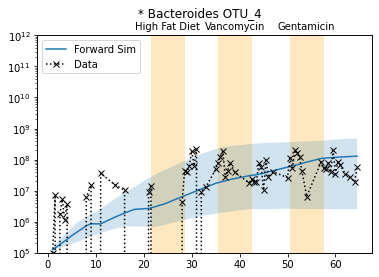

In [28]:
# Plot the forward sims, 25th-75th percentile
taxas = subj.taxas

low = np.percentile(M, q=25, axis=0)
high = np.percentile(M, q=75, axis=0)
med = np.percentile(M, q=50, axis=0)

oidx = 3

fig = plt.figure()
ax = fig.add_subplot(111)
ax.fill_between(times, y1=low[oidx, :], y2=high[oidx, :], alpha=0.2)
ax.plot(times, med[oidx,:], label='Forward Sim')
ax.plot(times, M_truth[oidx, :], label='Data', marker='x', color='black',
       linestyle=':')
ax.set_yscale('log')

md2.visualization.shade_in_perturbations(ax, perturbations=subj.perturbations, subj=subj)
ax.set_ylim(bottom=1e5, top=1e12)

ax.legend()

fig.suptitle(md2.taxaname_for_paper(taxas[oidx], taxas))
plt.show()

# Keystoneness
Calculate the keystoneness by using the `MDSINE2_Paper/keystoneness.py` script of the chain `uc100`.

Each line out table indicates which OTUs to leave out for that iteration of forward simulating to the steady state. Note that these are 0-based indecies for the OTUs.

In [29]:
# Make the leave out table - leave out each Cluster
os.makedirs('output/keystoneness', exist_ok=True)

mcmc = md2.BaseMCMC.load('output/mdsine2/uc100/mcmc.pkl')
clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
md2.generate_cluster_assignments_posthoc(clustering, set_as_value=True)
print(clustering)

txt = '\n'.join([','.join([str(oidx) for oidx in cluster.members]) for cluster in clustering])
f = open('output/keystoneness/leave_out_table.csv', 'w')
f.write(txt)
f.close()
print(txt)

!python ../keystoneness.py \
    --input output/mdsine2/uc0/mcmc.pkl \
    --study output/mdsine2/uc0/subjset.pkl \
    --leave-out-table output/keystoneness/leave_out_table.csv \
    --sep , \
    --simulation-dt 0.01 \
    --output-basepath output/keystoneness/ \
    --n-days 60

INFO:util.171: Number of clusters: 5
INFO:util.177: Clusters assigned: [2 2 0 0 4 1 1 0 3 0 2 0 1 1 1]


Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 2437674783520
	members: ['OTU_5']
	size: 1
Cluster 2437702550192
	members: ['OTU_3', 'OTU_4', 'OTU_8', 'OTU_10', 'OTU_13']
	size: 5
Cluster 2437702507208
	members: ['OTU_6', 'OTU_7', 'OTU_16', 'OTU_17', 'OTU_18']
	size: 5
Cluster 2437701401904
	members: ['OTU_1', 'OTU_2', 'OTU_12']
	size: 3
Cluster 2437683525952
	members: ['OTU_9']
	size: 1
4
2,3,7,9,11
5,6,12,13,14
0,1,10
8
(6, 15)
['OTU_1', 'OTU_2', 'OTU_3', 'OTU_4', 'OTU_5', 'OTU_6', 'OTU_7', 'OTU_8', 'OTU_9', 'OTU_10', 'OTU_12', 'OTU_13', 'OTU_16', 'OTU_17', 'OTU_18']


INFO:keystoneness.186: "all" provided as index. Iterating over each index
INFO:keystoneness.204: Forward simulating
INFO:keystoneness.209: Input is an MDSINE2.BaseMCMC object
INFO:keystoneness.241: not indexing out anything
INFO:keystoneness.80: 5/50 - 0.463132381439209
INFO:keystoneness.80: 10/50 - 0.4579734802246094
INFO:keystoneness.80: 15/50 - 0.4720015525817871
INFO:keystoneness.80: 20/50 - 0.4576094150543213
INFO:keystoneness.80: 25/50 - 0.4680001735687256
INFO:keystoneness.80: 30/50 - 0.4649982452392578
INFO:keystoneness.80: 35/50 - 0.4410088062286377
INFO:keystoneness.80: 40/50 - 0.4299910068511963
INFO:keystoneness.80: 45/50 - 0.4299795627593994
INFO:keystoneness.232: indexing out [4]
INFO:keystoneness.80: 5/50 - 0.4259762763977051
INFO:keystoneness.80: 10/50 - 0.4349648952484131
INFO:keystoneness.80: 15/50 - 0.4480018615722656
INFO:keystoneness.80: 20/50 - 0.4290337562561035
INFO:keystoneness.80: 25/50 - 0.4219655990600586
INFO:keystoneness.80: 30/50 - 0.45733022689819336
INF

['base', '4', '2,3,7,9,11', '5,6,12,13,14', '0,1,10', '8']



INFO:keystoneness.80: 15/50 - 0.4812486171722412
INFO:keystoneness.80: 20/50 - 0.47945594787597656
INFO:keystoneness.80: 25/50 - 0.49033451080322266
INFO:keystoneness.80: 30/50 - 0.46044206619262695
INFO:keystoneness.80: 35/50 - 0.4334745407104492
INFO:keystoneness.80: 40/50 - 0.4418177604675293
INFO:keystoneness.80: 45/50 - 0.43297481536865234
INFO:keystoneness.232: indexing out [8]
INFO:keystoneness.80: 5/50 - 0.4350001811981201
INFO:keystoneness.80: 10/50 - 0.4319760799407959
INFO:keystoneness.80: 15/50 - 0.44002628326416016
INFO:keystoneness.80: 20/50 - 0.44997572898864746
INFO:keystoneness.80: 25/50 - 0.4390244483947754
INFO:keystoneness.80: 30/50 - 0.42897558212280273
INFO:keystoneness.80: 35/50 - 0.4309992790222168
INFO:keystoneness.80: 40/50 - 0.4319918155670166
INFO:keystoneness.80: 45/50 - 0.4350011348724365
INFO:keystoneness.261: Make the table


In [30]:
# Display the steady state table
df_steady_state = pd.read_csv('output/keystoneness/uc-toy-dataset/steady-state-table.tsv',
                sep='\t', index_col=0)
df_steady_state.head()

,OTU_1,OTU_2,OTU_3,OTU_4,OTU_5,OTU_6,OTU_7,OTU_8,OTU_9,OTU_10,OTU_12,OTU_13,OTU_16,OTU_17,OTU_18
base,2.670436e+10,1.969166e+10,4.555215e+10,2526.566302,7.823614e+09,1.539024e+10,1.497396e+10,4.963507e+09,5.742269e+06,2.228771e+06,2.899325e+09,3.071144e+07,4.658999e+09,3.456649e+09,5.116738e+09
4,2.670436e+10,1.969166e+10,4.555215e+10,2526.566302,NaN,1.539376e+10,1.497474e+10,4.963507e+09,5.742269e+06,2.228771e+06,2.899325e+09,3.071144e+07,4.659555e+09,3.456997e+09,5.125440e+09
"2,3,7,9,11",2.670436e+10,1.969166e+10,NaN,NaN,7.823614e+09,1.539024e+10,1.497396e+10,NaN,5.742269e+06,NaN,2.899325e+09,NaN,4.658999e+09,3.456649e+09,5.116738e+09
"5,6,12,13,14",2.670436e+10,1.969166e+10,4.555215e+10,2526.566302,7.823614e+09,NaN,NaN,4.963507e+09,5.742269e+06,2.228771e+06,2.899325e+09,3.071144e+07,NaN,NaN,NaN
"0,1,10",NaN,NaN,4.555215e+10,2526.566302,7.823614e+09,3.965972e+10,4.132684e+10,4.963507e+09,5.742269e+06,2.228771e+06,NaN,3.071144e+07,7.624656e+09,5.800803e+09,1.565253e+10


In [31]:
# Display the keystoneness table
df_keystoneness = pd.read_csv('output/keystoneness/uc-toy-dataset/keystoneness.tsv',
                sep='\t', index_col=0)
df_keystoneness.head()

,l2 distance
4,9.440077e+06
"2,3,7,9,11",2.985001e-06
"5,6,12,13,14",0.000000e+00
"0,1,10",4.542909e+10
8,3.153365e+07


# Perturbation analysis

In [34]:
!python ../perturbation_analysis.py \
    --input output/mdsine2/uc0/mcmc.pkl \
    --study output/mdsine2/uc0/subjset.pkl \
    --leave-out-table output/keystoneness/leave_out_table.csv \
    --perturbation Vancomycin \
    --output-basepath output/keystoneness/pert_analysis \
    --start-perturbation 60 \
    --end-perturbation 120 \
    --n-days 180

<class 'mdsine2.pylab.base.Perturbations'>
0.01
120.0
60.0
180
18001
0.01
120.0
60.0
180
18001
0.01
120.0
60.0
180
18001
0.01
120.0
60.0
180
18001
0.01
120.0


INFO:perturbation_analysis.149: "all" provided as index. Iterating over each index
INFO:perturbation_analysis.169: Forward simulating
INFO:perturbation_analysis.174: Input is an MDSINE2.BaseMCMC object
INFO:perturbation_analysis.222: indexing out [4]
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001


60.0
180
18001


INFO:perturbation_analysis.57: 5/50 - 1.3480067253112793
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:perturbation_analysis.57: 10/50 - 1.3320338726043701
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:perturbation_analysis.57: 15/50 - 1.3279592990875244
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:perturbation_analysis.57: 20/50 - 1.3552391529083252
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics